# NLP: User experience multilabel classification

**Заказчик:** Samokat.Tech.

**Задача:** разработать модель для решения задачи множественной классификации обратной связи от пользователей по затронутым в тексте тематикам. Для каждого ответа из 50 различных меток классов необходимо выбрать все затронутые.

**Описание данных:**
 - `assessment` - пользовательская оценка.
 - `tags` - список тегов из ответа.
 - `text` - текст отзыва.
 - `trend_id_res0-49` -  таргет по каждому классу.

**Метрика:** `Accuracy`, рассчитанная через полное совпадение списка выбранных классов для каждого экземпляра.  
*Пример:* `accuracy_score(np.array([[0, 1], [1, 1]]), np.ones((2, 2)))  >>>  0.5`
<br><br>

**Структура проекта**
| Файл | Описание |
| --- | --- |
| **nlp_samokat.ipynb** | Текущий и основной файл проекта. |
| **[mlm_dataset.ipynb](mlm_dataset.ipynb)** | Процесс подготовки датасета для Masked Language Modeling. |
| **[eda.py](eda.py)** | Функции для разведочного анализа данных. |
| **[processing.py](processing.py)** | Функции для обработки данных. |
| **[experiment.py](experiment.py)** | Функции, связанные с проведением экспериментов и оценкой результатов. |
| **[custom_trainer.py](custom_trainer.py)** | Цикл обучения для DL моделей. |
| **[custom_metric.py](custom_metric.py)** | Пользовательские метрики. |
| **[utils.py](utils.py)** | Остальные функции. |
| **[submission.csv](submission.csv)** | Файл с предсказаниями для тестовой выборки |

<br>

**Stack:**  
`torch`, `transformers`, `numpy`, `scikit-learn`.

## Imports

In [1]:
# !pip install datasets
# !pip install peft
# !pip install googletrans

In [2]:
import re
import gc
import os
import random
from collections import Counter
from pathlib import Path
from tqdm.auto import tqdm
from termcolor import colored

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import train_test_split

import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchmetrics import MetricCollection
from torchmetrics.classification import (
    MulticlassAccuracy, 
    MultilabelPrecision, 
    MultilabelRecall, 
    MultilabelF1Score
)

from transformers import (
    AutoModel, 
    AutoModelForMaskedLM,
    AutoTokenizer, 
    DataCollatorWithPadding,
    DataCollatorForLanguageModeling,
    get_scheduler,
    TrainingArguments,
    Trainer,
)

from datasets import (
    Dataset, 
    DatasetDict, 
    load_dataset, 
    concatenate_datasets, 
    load_from_disk
)
from peft import get_peft_model, LoraConfig, TaskType

from utils import (
    Ansi,
    df_info,
    get_rare_labels_from_multihot,
    torch_device,
    get_model_size,
    get_requires_grad,
    check_unk_tokens,
    DataCollatorWithPaddingPlusLabels,
    DataCollatorWithRandomMasking,
)

from processing import(
    get_multihot_tags,
    drop_text_duplicates,
    prepare_data,
    x_y_split,
    back_translation,
    translation,
)

from eda import (
    hist_box_chart, 
    plot_counts, 
    boxplot_cnt_words_per_labels,
    cnt_words_chars,
    get_cnt_labels,
    get_cnt_classes_per_object,
    get_cnt_assessment,
    get_mean_assessments,
)

from experiment import (
    generate_emb, 
    get_metrics, 
    get_predict,
    show_predict,
)

from custom_metric import AccuracySamples
from custom_trainer import CustomTrainer

In [3]:
pd.set_option('display.max_rows', 200, 'display.max_colwidth', 400)

In [4]:
SEED = 42
DATASET = Path('data')
DEVICE = torch_device()

torch use: cuda (AMD Radeon RX 7800 XT)


In [5]:
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# Убрать, если GPU не от AMD.
os.environ['PYTORCH_HIP_ALLOC_CONF'] = 'expandable_segments:True'

## Load data

Загружаем данные.

In [6]:
train_df = pd.read_csv(DATASET / 'train.csv', index_col=0)
test_df = pd.read_csv(DATASET / 'test.csv', index_col=0)
trends_df = pd.read_csv(DATASET / 'trends_description.csv', index_col=0)
sample_submission = pd.read_csv(DATASET / 'sample_submission.csv', index_col=0)

In [7]:
df_info(train_df, isna_cols=['assessment', 'tags', 'text'])

,assessment,tags,text,trend_id_res0,trend_id_res1,trend_id_res2,trend_id_res3,trend_id_res4,trend_id_res5,trend_id_res6,...,trend_id_res40,trend_id_res41,trend_id_res42,trend_id_res43,trend_id_res44,trend_id_res45,trend_id_res46,trend_id_res47,trend_id_res48,trend_id_res49
index,,,,,,,,,,,,,,,,,,,,,
5652,6.0,"{ASSORTMENT,PROMOTIONS,DELIVERY}","Маленький выбор товаров, хотелось бы ассортимент больше, а так вроде бы все хорошо",0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18092,4.0,"{ASSORTMENT,PRICE,PRODUCTS_QUALITY,DELIVERY}",Быстро,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13845,6.0,"{DELIVERY,PROMOTIONS,PRICE,ASSORTMENT,SUPPORT}",Доставка постоянно задерживается,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
25060,6.0,"{PRICE,PROMOTIONS,ASSORTMENT}",Наценка и ассортимент расстраивают,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15237,5.0,"{ASSORTMENT,PRODUCTS_QUALITY,PROMOTIONS,CATALOG_NAVIGATION}",Доставка просто 👍,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Shape: (8708, 53)

Missing values:
assessment    230
tags           11
text            0


In [8]:
df_info(test_df)

,assessment,tags,text
index,,,
5905,5.0,{PROMOTIONS},"Крутая компания, удобное приложение"
3135,3.0,{DELIVERY},"Последнее время думаю плохо, сроки доставки давно не [NUM] мин, а цена услуг при этом выше аналогов"
9285,5.0,"{ASSORTMENT,PROMOTIONS}",Супер!!!
4655,2.0,"{PRICE,DELIVERY,ASSORTMENT}",Цены намного выше магазинных но радуют акции
16778,5.0,"{ASSORTMENT,PRODUCTS_QUALITY,PRICE,PROMOTIONS,CATALOG_NAVIGATION,PAYMENT,DELIVERY,SUPPORT}",Отлично


Shape: (16999, 3)

Missing values:
assessment    466
tags           32
text            2


In [9]:
# Заменим значения nan в поле с текстом в тестовом датасете на пустые строки
test_df['text'] = test_df['text'].fillna('')

In [10]:
df_info(trends_df)

,trend,explanation
trend_id,,
0,Долгая доставка,- долго везёте\n- очень долго везёте\n- сюда относим замечания без конкретики\n
1,Доставка стала долгой,"- клиент делает акцент на то, что раньше мы доставляли быстрее"
2,Время доставки не соответствует заявленому,"- клиент акцентирует внимание, что SLA не соотвесвует реальному времени доставки (всегда или часто)\n- в комментарии указывать, если клиент акцентирует внимание, что мы НИКОГДА не выдерживаем заявленное время доставки"
3,Регулярные опоздания,"- клиент акцентриет внимание, что мы часто/каждый заказ привозим заказ с опозданием"
4,Не отследить реальное время доставки,"- клиент говорит о том, что невозможно понять, когда приедет заказ\n- нет реального времени доставки\n- клиент задает вопрос ""где заказ""/""долго ли ждать"""


Shape: (50, 2)

Missing values:
trend          0
explanation    0


Признаки assessment и tags имеют некоторое количество пропусков в тренировочном и тестовом наборах данных. Так же в тестовом наборе у 2 объектов отсутствует текст комментария.

Составим словари для перевода индекса класса в название класса и обратно. То же самое повторим для тегов.

In [11]:
id2label = trends_df['trend'].to_dict()
label2id = {v: k for k, v in id2label.items()}
label_names = list(id2label.values())
num_labels = len(id2label)
label_cols = [f'trend_id_res{i}' for i in range(num_labels)]

id2label

{0: 'Долгая доставка',
 1: 'Доставка стала долгой',
 2: 'Время доставки не соответствует заявленому',
 3: 'Регулярные опоздания',
 4: 'Не отследить реальное время доставки',
 5: 'Курьер на карте',
 6: 'Нет доставки по адресу',
 7: 'Не предупреждаем об удалении товара',
 8: 'Высокая минимальная сумма заказа',
 9: 'Сумма заказа меняется во время набора корзины',
 10: 'Минимальная сумма заказа',
 11: 'Товары с подходящим сроком годности',
 12: 'Высокие цены',
 13: 'Не довезли товар',
 14: 'Товар испорчен во время доставки',
 15: 'Просроченные товары',
 16: 'Замечания по работе курьеров',
 17: 'Не читаем комментарии',
 18: 'Спасибо',
 19: 'Нет смысла',
 20: 'Всё нормально',
 21: 'Всё плохо',
 22: 'Скидки для постоянных клиентов',
 23: 'Больше акций/скидок',
 24: 'Скидка/промокод распространяется не на все товары',
 25: 'Непонятно как работает скидка',
 26: 'Не сработала скидка/акция/промокод',
 27: 'Качество товаров',
 28: 'Маленький ассортимент',
 29: 'Нет в наличии товара',
 30: 'Качеств

In [12]:
# Получаем список всех тегов
tags = set()
for tag in train_df['tags'].tolist():
    if not pd.isna(tag):
        tags.update(tag.strip('{}').split(','))

id2tag = {i: v for i, v in enumerate(sorted(tags))}
tag2id = {v: k for k, v in id2tag.items()}
tag_names = list(id2tag.values())
num_tags = len(id2tag)
tag_cols = [f'tag_{i}' for i in range(num_tags)]

id2tag

{0: 'ASSORTMENT',
 1: 'CATALOG_NAVIGATION',
 2: 'DELIVERY',
 3: 'PAYMENT',
 4: 'PRICE',
 5: 'PRODUCTS_QUALITY',
 6: 'PROMOTIONS',
 7: 'SUPPORT'}

Всего имеется 50 различных классов и 8 различных тегов.  
Для удобства теги представим в виде multi-hot векторов, аналогично классам.

In [13]:
train_df[tag_cols] = get_multihot_tags(train_df['tags'], tag2id)
test_df[tag_cols] = get_multihot_tags(test_df['tags'], tag2id)

train_df = train_df.drop('tags', axis=1)
test_df = test_df.drop('tags', axis=1)

In [14]:
train_df[['assessment', *tag_cols, 'text']].head()

,assessment,tag_0,tag_1,tag_2,tag_3,tag_4,tag_5,tag_6,tag_7,text
index,,,,,,,,,,
5652,6.0,1,0,1,0,0,0,1,0,"Маленький выбор товаров, хотелось бы ассортимент больше, а так вроде бы все хорошо"
18092,4.0,1,0,1,0,1,1,0,0,Быстро
13845,6.0,1,0,1,0,1,0,1,1,Доставка постоянно задерживается
25060,6.0,1,0,0,0,1,0,1,0,Наценка и ассортимент расстраивают
15237,5.0,1,1,0,0,0,1,1,0,Доставка просто 👍


В текстах отзывов присутствуют специальные токены, записанные в квадратных скобках, для скрытия некоторых данных. Пройдемся по всем текстам, найдем и посчитаем такие токены.

In [15]:
def cnt_patterns(texts: list[str], pattern=r'\[.*?\]'):
    special_tokens = Counter()
    for text in texts:
        findall = re.findall(pattern, text)
        special_tokens.update(findall)
    
    return special_tokens

special_tokens_train = cnt_patterns(train_df['text'].tolist())
special_tokens_test = cnt_patterns(test_df['text'].tolist())

print('Special tokens train:')
print('\n'.join([f"{k}: {v}" for k, v in special_tokens_train.items()]))

print('\nSpecial tokens test:')
print('\n'.join([f"{k}: {v}" for k, v in special_tokens_test.items()]))

Special tokens train:
[NUM]: 2524
[PHONE]: 3

Special tokens test:
[NUM]: 4988


В текстах присутствует большое количество токенов **[NUM]**, скорее всего все числа были заменены на такой текст. Убедимся в этом, используя в качестве паттерна для поиска любое количество цифр.

In [16]:
print(cnt_patterns(train_df['text'].tolist(), r'\d+'))
print(cnt_patterns(test_df['text'].tolist(), r'\d+'))

Counter()
Counter()


Вернулись пустые счетчики, значит ни одного числа в текстах нет. Так же в тренировочном наборе данных есть 3 токена **[PHONE]** для сокрытия номеров телефона.

Почистим тексты комментариев от лишних пробелов, переносов строк и т.д

In [17]:
def clean_text(text):
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'\uFFFC', '', text)
    return text

train_df['text'] = train_df['text'].apply(clean_text)
test_df['text'] = test_df['text'].apply(clean_text)

## EDA

Выясним, тексты какой длины представлены в датасете.

In [18]:
train_cnt_words, train_cnt_chars = cnt_words_chars(train_df['text'].tolist())
test_cnt_words, test_cnt_chars = cnt_words_chars(test_df['text'].tolist())

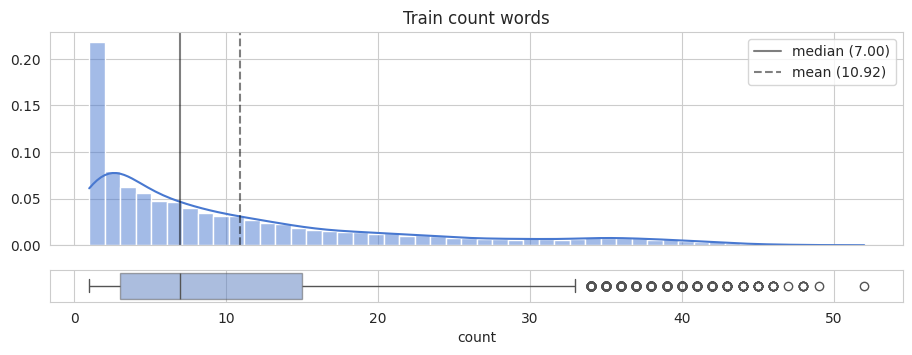

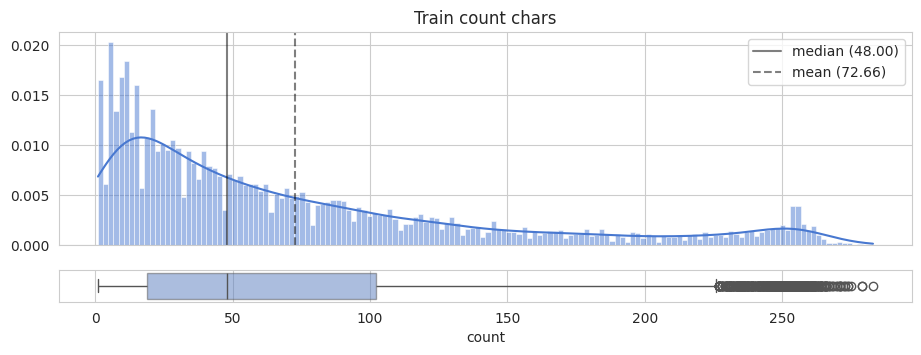

In [19]:
hist_box_chart(train_cnt_words, 'Train count words')
hist_box_chart(train_cnt_chars, 'Train count chars')

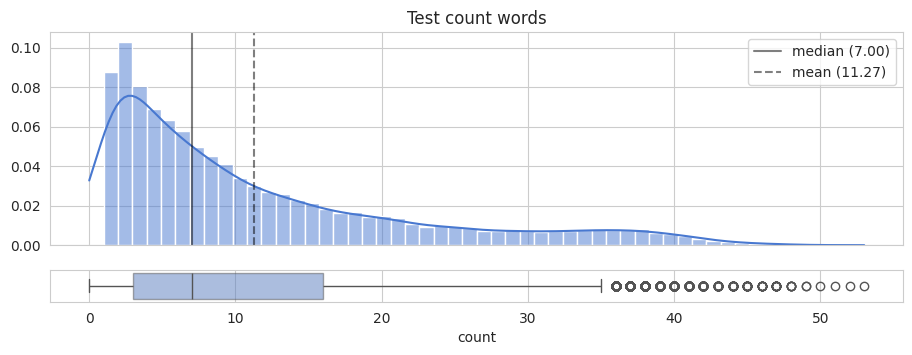

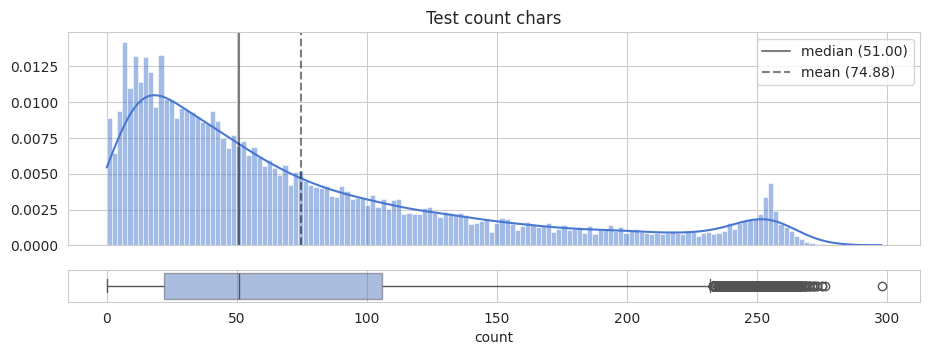

In [20]:
hist_box_chart(test_cnt_words, 'Test count words')
hist_box_chart(test_cnt_chars, 'Test count chars')

Распределения длин отзывов в тренировочном и тестовом наборе данных примерно одинаковые. Текстовые комментарии относительно небольшие - медианная длина составляет **7** слов, а средняя - около **11**. Если говорить про отдельные символы - то медиана **~50**, среднее **~73.**  
Такие распределения с длинным правым хвостом похожи на логнормальные. Выбросы справа на графиках количества символов можно объяснить тем, что в сервисе установлено ограничение на максимальное количество символов в отзыве примерно на 260. Т.к. в отзывах все числа заменены на **[NUM]** при постобработке, то часть озывов могла получиться несколько длиннее максимального ограничения.

Взглянем на частоту встречаемости классов в размеченной части датасета.  
В **круглых скобках** на графике указано количество экземпляров данного класса во всем датасете.  
В **квадратных скобках** - индекс класса от 0 до 49.

In [21]:
label_names_with_id = list(f"{name} [{idx:>2}]" for name, idx in label2id.items())

counts = get_cnt_labels(label_names, train_df[label_cols].to_numpy(), sorted_values=False)[0].values()
label_names_with_id_and_cnt = list(f"{name} ({cnt:>3}) [{idx:>2}]" for (name, idx), cnt in zip(label2id.items(), counts))

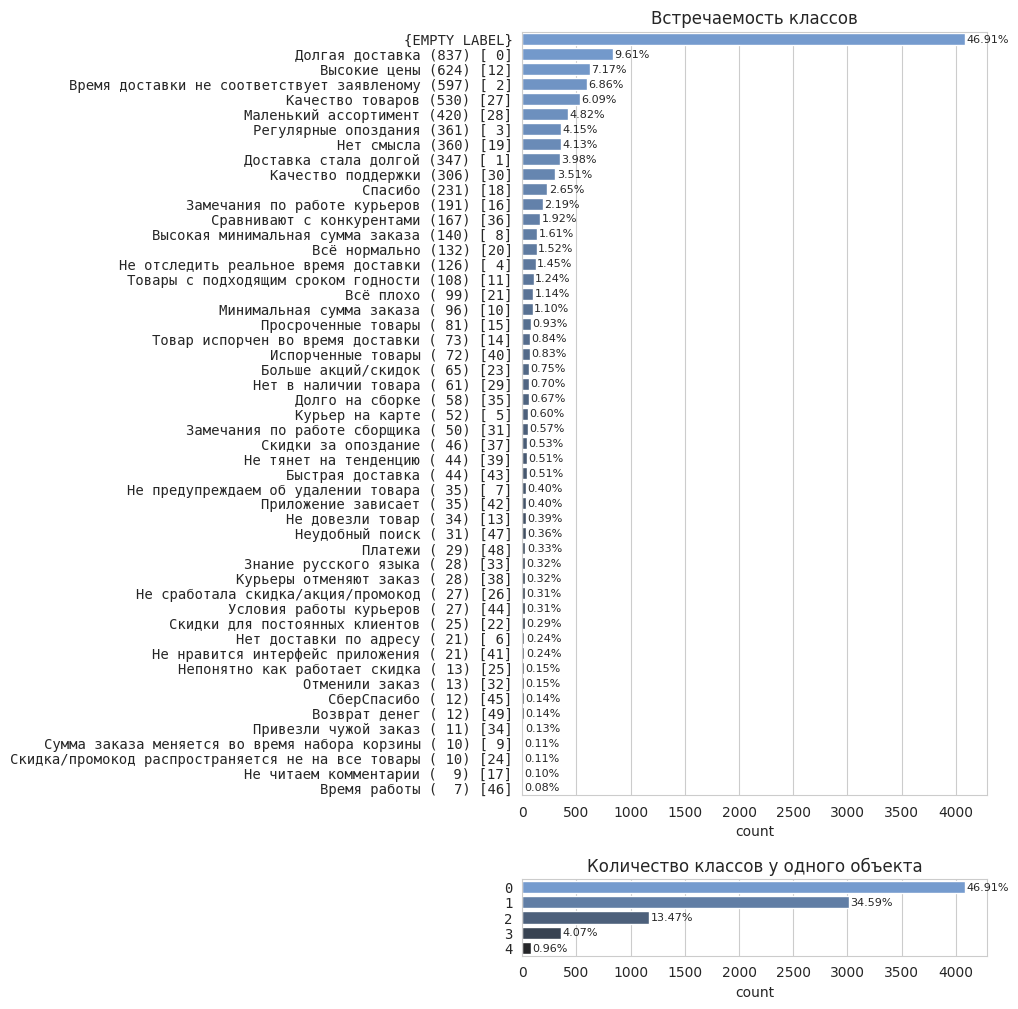

In [22]:
fig, ax = plt.subplots(2, 1, figsize=(6, 12), gridspec_kw={'height_ratios': [1, .1]})

data, num_samples = get_cnt_labels(label_names_with_id_and_cnt, train_df[label_cols].to_numpy())
plot_counts(data, num_samples, 'Встречаемость классов', ax=ax[0])

data, num_samples = get_cnt_classes_per_object(train_df[label_cols].to_numpy())
plot_counts(data, num_samples, 'Количество классов у одного объекта', ax=ax[1])

plt.show()

Наблюдается выраженный дисбаланс классов. Видим, что почти 47% выборки не отнесена ни к одному классу. Некоторые классы представлены всего парой десятков примеров. Так для 25 классов (т.е. для половины) в выборке найдется 50 или менее примеров для каждого.  
Так же стоит отметить что некоторые объекты могут быть отнесены сразу к нескольким классам; а 1 % всех объектов имеет сразу 4 метки.

Далее рассмотрим, как связаны длина отзыва с таргетом.

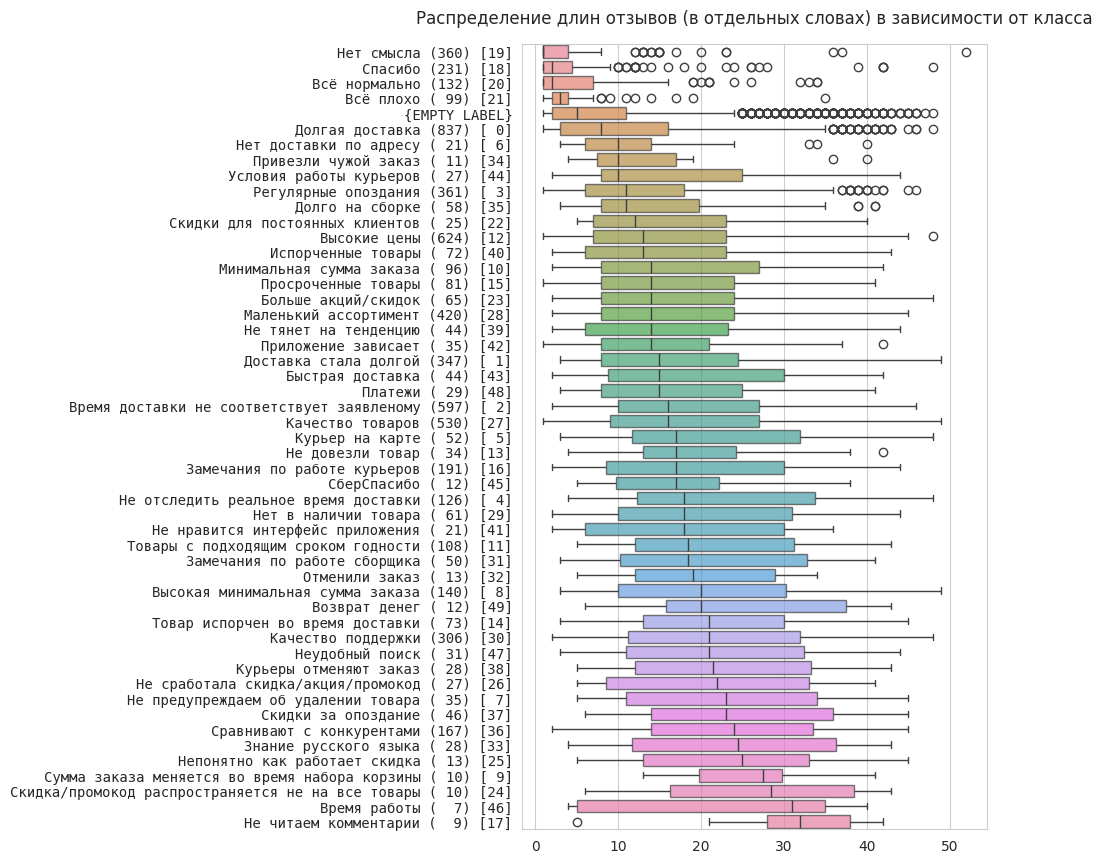

In [23]:
boxplot_cnt_words_per_labels(
    train_df['text'].to_list(), 
    label_names_with_id_and_cnt, 
    train_df[label_cols].to_numpy(), 
    title='Распределение длин отзывов (в отдельных словах) в зависимости от класса'
)

В целом, прослеживается зависимость длины отзыва от категории, что может свидетельствовать о разной степени детализации, необходимой для выражения недовольства или похвалы по конкретным темам. Бессмысленные сообщения, сообщения с благодарностью, или о том, что "все плохо" как правило содержат всего пару слов - и примеров таких объектов в датасете довольно много. Из значимых категорий (по количеству отзывов), которые имеют тенденцию к относительно большим длинам текстов, можно отметить - "Сравнивают с конкурентами", "Качество поддержки" и "Высокая минимальная сумма заказа", имеющие медианную длину 20 и более слов.

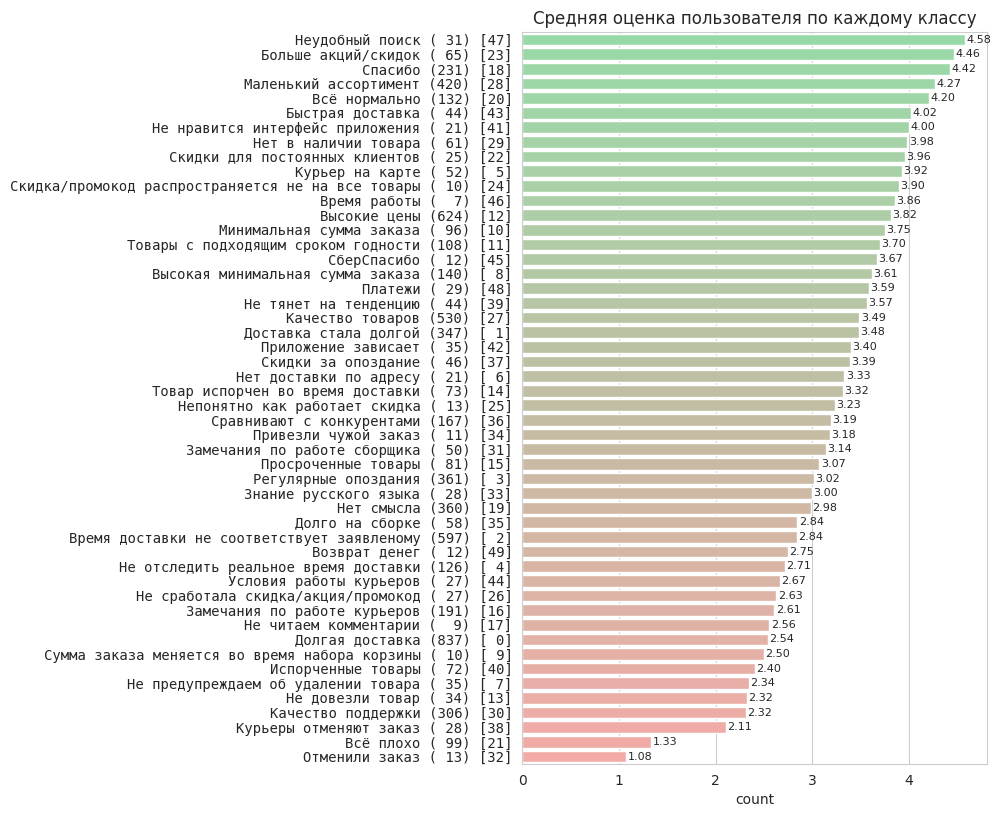

In [24]:
data = get_mean_assessments(label_names_with_id_and_cnt, train_df[label_cols].to_numpy(), train_df['assessment'].to_numpy())
plot_counts(data, title = 'Средняя оценка пользователя по каждому классу', palette='blend:#8de5a1,#ff9f9b')

Средняя оценка так же коррелирует с категорией отзыва. Внизу графика с минимальным рейтингом идут отзывы со следующими категориями: "Не довезли товар", "Качество" поддержки", "Курьеры отменяют заказ" и "Всё плохо", что логично. Хотя наблюдать "Неудобный поиск" в самом верху графика несколько странно. Возможно это связано с недостаточным объемом выборки.

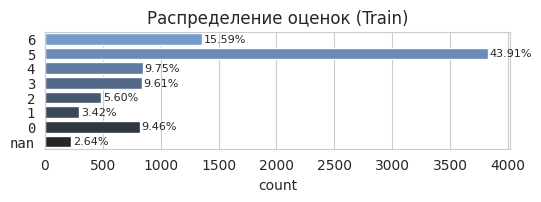

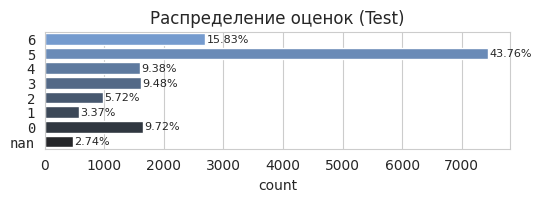

In [25]:
data, num_samples = get_cnt_assessment(train_df['assessment'])
plot_counts(data, num_samples, 'Распределение оценок (Train)')

data, num_samples = get_cnt_assessment(test_df['assessment'])
plot_counts(data, num_samples, 'Распределение оценок (Test)')

Большинство оценок, почти **44%**, равняются 5, что в тестовой, что в тренировочной выборках.

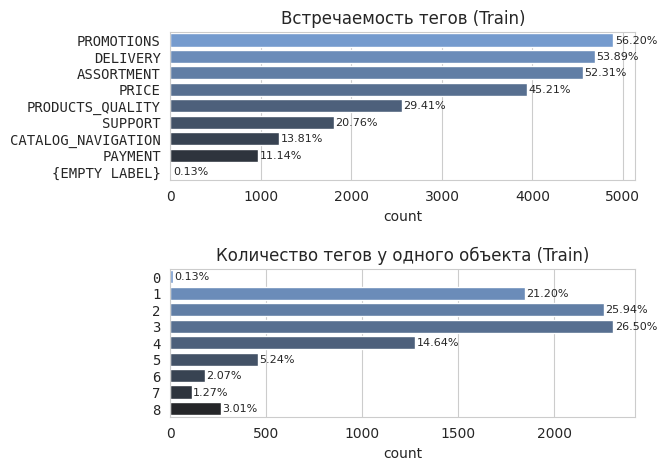

In [26]:
fig, ax = plt.subplots(2, 1, figsize=(6, 5))
fig.subplots_adjust(hspace=.6)

data, num_samples = get_cnt_labels(tag_names, train_df[tag_cols].to_numpy())
plot_counts(data, num_samples, 'Встречаемость тегов (Train)', ax=ax[0])

data, num_samples = get_cnt_classes_per_object(train_df[tag_cols].to_numpy())
plot_counts(data, num_samples, 'Количество тегов у одного объекта (Train)', ax=ax[1])

plt.show()

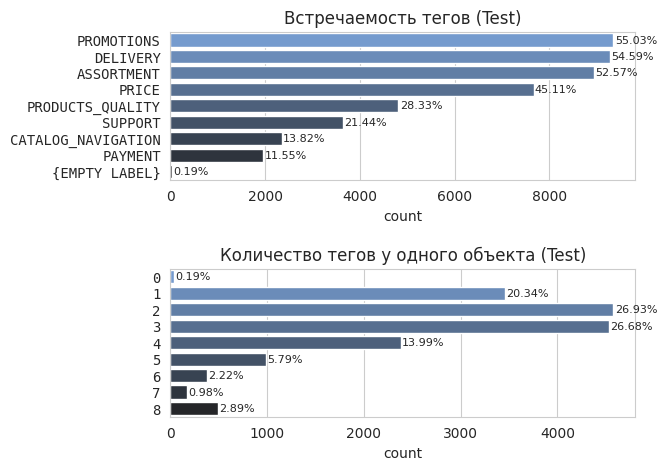

In [27]:
fig, ax = plt.subplots(2, 1, figsize=(6, 5))
fig.subplots_adjust(hspace=.6)

data, num_samples = get_cnt_labels(tag_names, test_df[tag_cols].to_numpy())
plot_counts(data, num_samples, 'Встречаемость тегов (Test)', ax=ax[0])

data, num_samples = get_cnt_classes_per_object(test_df[tag_cols].to_numpy())
plot_counts(data, num_samples, 'Количество тегов у одного объекта (Test)', ax=ax[1])

plt.show()

## Data processing

### Drop duplicates

Для начала посчитаем и удалим полные дубликаты в размеченных данных.

In [28]:
print('Удалено полных дубликатов:', colored(train_df.duplicated().sum(), attrs=['bold']))
train_df = train_df.drop_duplicates()
print('Текущий размер датасета:', colored(train_df.shape[0], attrs=['bold']))

Удалено полных дубликатов: 328
Текущий размер датасета: 8380


Поочередно уберем из выборки по одному признаку (список классов и список тегов примем каждый за один признак) и посчитаем количество дубликатов

In [29]:
print('Дубликаты без учета tags:', colored(train_df.drop(tag_cols, axis=1).duplicated().sum(), attrs=['bold']))
print('Дубликаты без учета labels:', colored(train_df.drop(label_cols, axis=1).duplicated().sum(), attrs=['bold']))
print('Дубликаты без учета assessment:', colored(train_df.drop('assessment', axis=1).duplicated().sum(), attrs=['bold']))
print('Дубликаты текстов:', colored(train_df['text'].duplicated().sum(), attrs=['bold']))

Дубликаты без учета tags: 602
Дубликаты без учета labels: 0
Дубликаты без учета assessment: 65
Дубликаты текстов: 897


Видим, что если из данных удалить информацию о тегах, то появляется **602** дубликата, а это примерно **7.2%** от всех данных в датасете. Соответственно, можно сделать предположение, что данный признак не несет в себе какой-то полезной информации и является шумом. В пользу этой версии говорит еще и то, что всего при **8** уникальных признаках в нашем датасете более **25%** данных имеют по **4 и более** тегов (это видно по графику выше). Добавление такого признака в модель классификации, скорее всего, в лучшем случае не повлияет на качество, а в худшем его ухудшит. Поэтому данный признак можно убрать из данных и снова удалить дубликаты.

In [30]:
train_df = train_df.drop(tag_cols, axis=1)

print('Удалено полных дубликатов:', colored(train_df.duplicated().sum(), attrs=['bold']))
train_df = train_df.drop_duplicates()
print('Текущий размер датасета:', colored(train_df.shape[0], attrs=['bold']))

Удалено полных дубликатов: 602
Текущий размер датасета: 7778


In [31]:
print('Дубликаты без учета labels:', colored(train_df.drop(label_cols, axis=1).duplicated().sum(), attrs=['bold']))
print('Дубликаты без учета assessment:', colored(train_df.drop('assessment', axis=1).duplicated().sum(), attrs=['bold']))
print('Дубликаты текстов:', colored(train_df['text'].duplicated().sum(), attrs=['bold']))

Дубликаты без учета labels: 12
Дубликаты без учета assessment: 160
Дубликаты текстов: 295


Как видно, в данных все еще остались дубликаты текстов. Так же имеются пропуски в assessment и много объектов, которые не принадлежат ни к одному классу. На данном этапе разделим датасет на условно "чистый" и "грязный". К чистым отнесем объекты, принадлежащие хотя бы к одному классу, без пропусков в оценке пользователя, и не имеющие дубликатов текстов. Пропуски попробуем заполнить позже.

In [32]:
# Вспомогательный столбец, показывающий наличие полного дубликата текста среди других данных
train_df['is_duplicate'] = train_df['text'].duplicated(keep=False)

def is_dirty(row, label_cols):
    isna_labels = row[label_cols].sum() == 0
    isna_urating = pd.isna(row['assessment'])
    is_duplicate = row['is_duplicate']
    return isna_labels or isna_urating or is_duplicate

idx_dirty = train_df.apply(is_dirty, axis=1, label_cols=label_cols)
# Удаляем временный столбец
train_df = train_df.drop('is_duplicate', axis=1)

In [33]:
clean_df, dirty_df = train_df[~idx_dirty], train_df[idx_dirty]

print('clean size:', colored(clean_df.shape[0], attrs=['bold']))
print('dirty size:', colored(dirty_df.shape[0], attrs=['bold']))

clean size: 4137
dirty size: 3641


### Train valid split

Теперь от "чистой" части датасета отделим валидационную выборку, что бы можно было объективно оценивать качество моделей. После этого попробуем заполнить пропуски в "грязных" данных на основе тренировочной выборки. Если заполнять пропуски до разделения на train и val, то это скорее всего приведет к утечке данных и сделает валидационную выборку менее репрезентативной.

При разделении на выборки воспользуемся стратификацию по классам. Т.к. один объект может принадлежать сразу к нескольким классам, то при стратификации (для простоты расчетов) такие объекты будут считаться принадлежащими к самому малочисленному (во всем датасете) из своих классов.

In [34]:
labels = clean_df[label_cols].to_numpy()
rare_labels = get_rare_labels_from_multihot(labels)

Разделяем датасет на тренировочный и валидационный

In [35]:
train_df, val_df = train_test_split(
    clean_df, 
    test_size=.2, 
    shuffle=True, 
    stratify=rare_labels,
    random_state=SEED,
)

In [36]:
print(f"{'train size:':<11}", colored(train_df.shape[0], attrs=['bold']))
print(f"{'dirty size:':<11}", colored(dirty_df.shape[0], attrs=['bold']))
print(f"{'val size:':<11}", colored(val_df.shape[0], attrs=['bold']))
print(f"{'test size:':<11}", colored(test_df.shape[0], attrs=['bold']))

train size: 3309
dirty size: 3641
val size:   828
test size:  16999


### Drop text duplicates

Для одинаковых текстов результирующая пользовательская оценка берется как среднее всех оценок для данного текста.

Вычисление результирующего массива классов производится по следующему алгоритму:
1. Если у объектов с выбранным текстом все классы нулевые, то результирующий массив так же будет нулевой.
2. Если только один объект будет иметь хотя бы один ненулевой класс, то результирующим массив будет копией классов данного объекта.
3. Если ненулевые классы будут иметь два объекта, то результирующий массив будет состоять из классов, которые присутствуют в обоих ненулевых объектах.
4. Если ненулевые классы будут у 3 и более объектов, то результирующий массив будет состоять из классов, которые присутствуют хотя бы в половине ненулевых объектов.


In [37]:
duplicated_mask = dirty_df['text'].duplicated(keep=False)
unduplicated_df = drop_text_duplicates(dirty_df[duplicated_mask], label_cols)

miss_idx = np.all(unduplicated_df[label_cols].to_numpy() == 0, axis=1)

print('Общее количество текстов, имеющих дубли:', colored(duplicated_mask.sum(), attrs=['bold']))
print('Количество уникальных значений:', colored(unduplicated_df.shape[0], attrs=['bold']))
print('Из которых хотя бы один класс имеет:', colored((~miss_idx).sum(), attrs=['bold']))

print('\nКоличество пропусков в столбце assessment в unduplicated_df:', colored(unduplicated_df['assessment'].isna().sum(), attrs=['bold']))

Общее количество текстов, имеющих дубли: 468
Количество уникальных значений: 173
Из которых хотя бы один класс имеет: 141

Количество пропусков в столбце assessment в unduplicated_df: 0


Объекты, которым удалось присвоить хотя бы один класс переместим в тренировочную выборку, остальные оставим в dirty_df.

In [38]:
dirty_df = pd.concat([dirty_df[~duplicated_mask], unduplicated_df[miss_idx]])
train_df = pd.concat([train_df, unduplicated_df[~miss_idx]])

train_df = train_df.reset_index(drop=True)
dirty_df = dirty_df.reset_index(drop=True)

print('train size:', colored(train_df.shape[0], attrs=['bold']))
print('dirty size:', colored(dirty_df.shape[0], attrs=['bold']))

train size: 3450
dirty size: 3205


## Text augmentation

Для того, что бы несколько скомпенсировать дисбаланс классов и увеличить количество представителей минорных классов, воспользуемся такой техникой аугментаций текста как обратный перевод или же back translation. При таком подходе текст переводится с родного на иностранный язык а затем обратно. Данная операция позволяет несколько перефразировать исходный текст, в большинстве случаев сохранив исходный смысл. Воспользуемся библиотекой `googletrans`, которая работает с API Google Translate.  

Для создания выборки текстов для подачи в back translation воспользуемся семплированием.

In [39]:
labels = train_df[label_cols].to_numpy()

class_count = labels.sum(axis=0)
class_weights = 1 / class_count

# Обнулим веса для 8 самых распространенных классов. Это полностью не исключит из
# списка подобные объекты, так как в паре с такими классами могут идти минорные у одного объекта.
zero_weights = np.argsort(class_count)[::-1][:8]
class_weights[zero_weights] = 0

sample_weigths = (labels * class_weights).sum(axis=1)

backtrans_df = train_df.sample(n=3000, replace=True, weights=sample_weigths, random_state=SEED)

Так как в Google Translate на момент начала 2025 года представлено 245 языков, то логичным будет предположить, что при переводе на редко встречающиеся языки смысл текста с большей вероятностью подвергнется критическому искажению, чем при использовании распространенных языков. Так же некоторые языковые пары работают лучше других. Для того, что бы составить список наиболее подходящих языков, которые при работе с русским языком будут давать наиболее приемлемое качество, обратимся к ChatGPT.

In [40]:
# Этот список охватывает языки, которые наиболее точно сохраняют смысл при переводе с русского и обратно. Конечно, точность перевода может варьироваться в зависимости от сложности и специфики текстов, но эти языковые пары, как правило, показывают хорошие результаты в задачах back translation.

langs = [
    'en',  # English
    'es',  # Spanish
    'fr',  # French
    'de',  # German
    'it',  # Italian
    'pt',  # Portuguese
    'zh-cn',  # Simplified Chinese
    'zh-tw',  # Traditional Chinese
    'ja',  # Japanese
    'ko',  # Korean
    'tr',  # Turkish
    'pl',  # Polish
    'nl',  # Dutch
    'cs',  # Czech
    'da',  # Danish
    'fi',  # Finnish
    'sv',  # Swedish
    'no',  # Norwegian
    'hu',  # Hungarian
    'el',  # Greek
    'he',  # Hebrew
    'bg',  # Bulgarian
    'ro',  # Romanian
    'uk',  # Ukrainian
    'lv',  # Latvian
    'lt',  # Lithuanian
    'et',  # Estonian
    'sk',  # Slovak
    'sl',  # Slovenian
    'hr',  # Croatian
    'sr',  # Serbian
    'mk',  # Macedonian
    'hi',  # Hindi
    'id',  # Indonesian
    'vi',  # Vietnamese
    'th',  # Thai
    'ms',  # Malay
    'fa',  # Persian
    'ar',  # Arabic
    'ur',  # Urdu
]

In [41]:
%%time
backtrans_df['text_backtrans'] = back_translation(backtrans_df['text'].tolist(), range_num_langs=(1, 1), target_langs=langs) 

CPU times: user 9.36 s, sys: 184 ms, total: 9.55 s
Wall time: 10.6 s


Сравнение оригинального текста и дважды переведенного.

In [42]:
backtrans_df[['text', 'text_backtrans']].sample(10)

,text,text_backtrans
2459,"Было бы удобно, если можно было бы посмотреть, где находится курьер, когда везёт заказ. Если потеряется, то можно было бы ему позвонить (что тоже было бы удобно, если можно было связаться напрямую с курьером)","Было бы удобно, если бы можно было видеть, где находится курьер, когда доставляет заказ. Если он потеряется, вы можете позвонить ему (что также было бы удобно, если бы вы могли связаться с курьером напрямую)"
190,"Несколько раз привозили испорченные продукты, заказываю только то, что долго хранится","Несколько раз доставляли бракованный товар, заказываю только то, что может храниться долго."
2564,Хотелось бы что бы все напитки были охлажденными. А вы привозите теплыми,"Я бы хотел, чтобы все напитки были охлажденными. Вы носите его в тепле?"
1208,"Устал получать раздавленные бутылками продукты типа сырков и прочего. Неужели не хватает интеллекта положить эти сырки хотя бы сверху в пакет, а не вниз?","Я устал получать такие продукты, как творог и другие измельченные продукты в бутылках. Неужели не хватает ума положить эти сырки хотя бы сверху сумки, а не на дно?"
313,"Все плохо , после того как прошла оплата через [NUM] минут , написали что заказ отменен и вернули деньги","Все плохо, после того как оплата прошла [NUM] минут, написали, что заказ отменен и деньги возвращены"
2959,"Постоянно задерживается доставка, то курьера найти не могут, то в приложении пишут «курьер будет через [NUM] минуты», а в итоге [NUM]-[NUM] минут проходит. Продукты привозят хорошие, жалоб нет, все сроки свежие, овощи и фрукты замечательные. Но постоянные опоздания","Доставка постоянно задерживается, иногда не могу найти курьера, и хотя в заявке я написала, что ""курьер прибудет через [NUM] минут"", в итоге это заняло [NUM] - [NUM] минут. Продукты привозят хорошие, претензий нет, все финики свежие, овощи и фрукты отличные. Но задержка продолжается"
318,"Не знаю от чего это зависит. Но бывает когда заказываешь доставку, мало того что она вся побитая, помятая, придет! Так еще и продукты просроченные.","Я не знаю, от чего это зависит. Но ведь так бывает, когда вы заказываете доставку, а получаете не только потрепанное, но и помятое! Кроме того, срок годности продукта истек."
3005,"Очень удобно, стоимость выше, но это нивелируется удобством, еще б доставка порой до часа не доходила, иначе весь смысл сервиса теряется. Если скорость и дальше будет большой, тот же сбермаркет побеждает по скорости/стоимости","Это очень удобно, цена выше, но это компенсируется практичностью, даже если иногда доставка не заняла бы и часа, иначе весь смысл услуги был бы потерян. Если скорость еще высокая, то по скорости/стоимости выигрывает тот же Сбермаркет"
3028,"Несколько раз привозили просрочку. Система скидок дурацкая- накручиваете цену, потом делаете ""скидку"", а собственная скидка уже не пройдет, применяется бОльшая))))","Несколько раз доставляли с опозданием. Система скидок дурацкая - увеличиваешь цену, потом даешь ""скидку"", но своя скидка уже не подействует, будет использована большая))))"
2223,"Последнее время постоянные проблемы с доставкой заказов, долго везут, либо абсолютно не то что заказывала","В последнее время мы испытываем много проблем с доставкой, например, заказы приходят долго или совершенно не соответствуют тому, что мы заказали."


In [43]:
backtrans_df = backtrans_df.drop('text', axis=1).rename({'text_backtrans': 'text'}, axis=1)

In [44]:
train_aug_df = pd.concat([train_df, backtrans_df])

print('Количество дубликатов для удаления после объединения датасетов:', colored(train_aug_df.duplicated().sum(), attrs=['bold']))
train_aug_df = train_aug_df.drop_duplicates()
print('Итоговый размер тренировочного датасета:', colored(train_aug_df.shape[0], attrs=['bold']))

Количество дубликатов для удаления после объединения датасетов: 464
Итоговый размер тренировочного датасета: 5986


Сравним соотношения классов в оригинальной выборке и после добавления аугментаций.

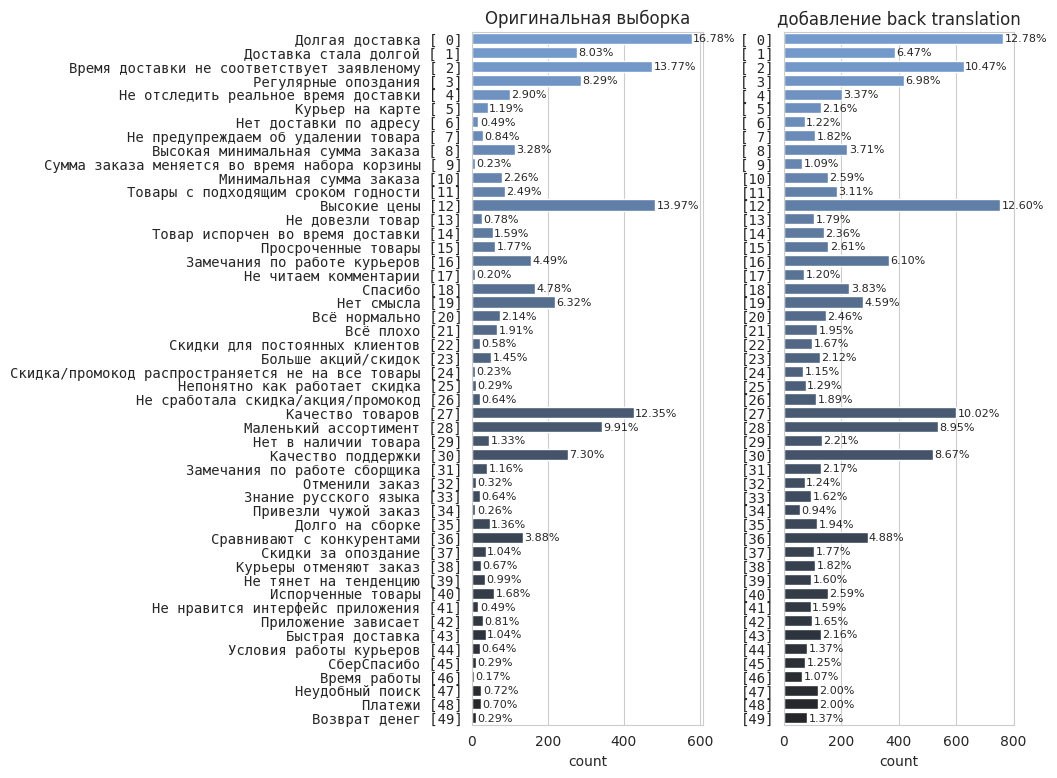

In [45]:
fig, ax = plt.subplots(1, 2, figsize=(7, 9), gridspec_kw={'wspace': .35})

data, num_samples = get_cnt_labels(label_names_with_id, train_df[label_cols].to_numpy(), sorted_values=False)
plot_counts(data, num_samples, 'Оригинальная выборка', ax=ax[0])

data, num_samples = get_cnt_labels([f"[{i:>2}]" for i in range(num_labels)], train_aug_df[label_cols].to_numpy(), sorted_values=False)
plot_counts(data, num_samples, 'добавление back translation', ax=ax[1])

plt.show()

Видно, что таким способом удалось несколько повысить количество минорных классов в выборке.

## (1) Logistic regression + BERT embeddings

### Get BERT embeddings

В качестве модели для эмбеддингов возьмем [**sergeyzh/LaBSE-ru-turbo**](https://huggingface.co/sergeyzh/LaBSE-ru-turbo). Архитектурно это тот же BERT. Данная модель была выбрана по причине того, что в лидерборде на русскоязычной части датасета [**MTEB**](https://huggingface.co/spaces/mteb/leaderboard) занимает высокое место среди относительно компактных моделей. А так же показывает хорошее качество "из коробки" на нашей задаче.

In [46]:
model_name = 'sergeyzh/LaBSE-ru-turbo'

model_bert = AutoModel.from_pretrained(model_name).to(DEVICE)
tokenizer = AutoTokenizer.from_pretrained(model_name)

get_model_size(model_bert)

Model_size: 128.35M params

In [47]:
train_data = prepare_data(train_aug_df, label_cols)
val_data = prepare_data(val_df, label_cols)
test_data = prepare_data(test_df)

Сформируем эмбеддинги и представим данные в формате, подходящем для моделей из sklearn.

In [48]:
train_emb = generate_emb(model_bert, tokenizer, train_data['sentences'], batch_size=64)
val_emb = generate_emb(model_bert, tokenizer, val_data['sentences'], batch_size=64)

X_train, y_train = x_y_split(train_data, train_emb)
X_val, y_val = x_y_split(val_data, val_emb)

Map:   0%|          | 0/5986 [00:00<?, ? examples/s]

generate_embeddings:   0%|          | 0/94 [00:00<?, ?it/s]

/home/lake/anaconda3/envs/lime/lib/python3.11/site-packages/torch/nn/modules/linear.py:125: UserWarning: Attempting to use hipBLASLt on an unsupported architecture! Overriding blas backend to hipblas (Triggered internally at ../aten/src/ATen/Context.cpp:296.)
  return F.linear(input, self.weight, self.bias)
/home/lake/anaconda3/envs/lime/lib/python3.11/site-packages/transformers/models/bert/modeling_bert.py:440: UserWarning: Memory Efficient attention on Navi31 GPU is still experimental. Enable it with TORCH_ROCM_AOTRITON_ENABLE_EXPERIMENTAL=1. (Triggered internally at ../aten/src/ATen/native/transformers/hip/sdp_utils.cpp:269.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


Map:   0%|          | 0/828 [00:00<?, ? examples/s]

generate_embeddings:   0%|          | 0/13 [00:00<?, ?it/s]

### Constant model

В качестве низшей границы качества возьмем константную модель.

Accuracy:       0.0000 (samples)
BCE:            0.1168

                micro     macro  weighted   samples
F1:             0.00      0.00      0.00      0.00
Precision:      0.00      0.00      0.00      0.00
Recall:         0.00      0.00      0.00      0.00



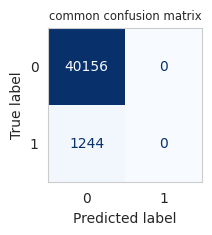

In [49]:
model_dummy = MultiOutputClassifier(DummyClassifier())
model_dummy.fit(X_train, y_train)
pred_dummy = model_dummy.predict_proba(X_val)
pred_dummy = np.array(pred_dummy)[:, :, 1].transpose(1, 0)

get_metrics(pred_dummy, y_val, detail_stat=False)

Как и ожидалось, Accuracy получилась 0, так как для всех объектов и всех классов предсказано самое частое значение, т.е. 0 - отсутствие класса.

### Logistic regression

Accuracy:       0.3611 (samples)
BCE:            0.0814

                micro     macro  weighted   samples
F1:             0.62      0.44      0.60      0.58
Precision:      0.67      0.53      0.66      0.61
Recall:         0.57      0.40      0.57      0.60



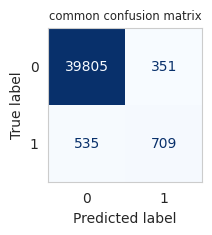


metrics for each class:
id         F1      P      R     num
 0        66%    65%    67%     145
 1        62%    65%    60%      65
 2        69%    76%    64%     121
 3        52%    58%    48%      67
 4        37%    47%    31%      26
 5        74%    88%    64%      11
 6        75%    75%    75%       4
 7        44%    67%    33%       6
 8        49%    61%    41%      27
 9         0%     0%     0%       2
10        29%    29%    28%      18
11        75%    83%    68%      22
12        89%    89%    89%     116
13         0%     0%     0%       7
14        33%    67%    22%      18
15        32%    80%    20%      20
16        56%    56%    56%      36
17         0%     0%     0%       2
18        57%    57%    57%      30
19        58%    73%    48%      50
20        27%    27%    27%      15
21        53%    53%    53%      15
22        57%   100%    40%       5
23        48%    60%    40%      15
24         0%     0%     0%       2
25         0%     0%     0%       3
26 

In [50]:
model_lr = MultiOutputClassifier(LogisticRegression(max_iter=10000, random_state=SEED))
model_lr.fit(X_train, y_train)
pred_lr = model_lr.predict_proba(X_val)
pred_lr = np.array(pred_lr)[:, :, 1].transpose(1, 0)

get_metrics(pred_lr, y_val)

Получаем Accuracy **0.3587** (по полному совпадению меток классов для каждого объекта) - это будет нашей точкой отсчета.  
Видно, что для многих минорных классов получаем качество ниже среднего. В ходе экспериментов было установлено, что дальнейшем увеличении числа аугмунтаций с помощью back translation ведет скорее к ухудшению метрик. Вероятно, что существует некий предел эффективности использования аугментаций back translation. После определенного количества новые примеры перестают приносить пользу, а могут даже ухудшать обучение, вызывая переобучение модели на ограниченном наборе шаблонов.

Взглянем на несколько примеров работы данной модели в сравнении с ground truth.

In [51]:
show_predict(pred_lr, y_val, val_data['sentences'], id2label, nums=3, random_samples=True)

Sentence: Пока хорошо👌
BCE: 0.0071

True labels:
  18: (80.6%) Спасибо

Pred labels (top 5):
  18: (80.6%) Спасибо
   0: (12.5%) Долгая доставка
  19:  (0.6%) Нет смысла
  21:  (0.0%) Всё плохо
  27:  (0.0%) Качество товаров
Sentence: Маленький ассортимент. Мало акций
BCE: 0.0003

True labels:
  23: (100.0%) Больше акций/скидок
  28: (100.0%) Маленький ассортимент

Pred labels (top 5):
  28: (100.0%) Маленький ассортимент
  23: (100.0%) Больше акций/скидок
  24:  (0.8%) Скидка/промокод распространяется не на все товары
  29:  (0.5%) Нет в наличии товара
  12:  (0.0%) Высокие цены
Sentence: Маленький выбор товара, неудобные разделы, постоянные задержки с доставкой, и вечно лагающее приложение.
BCE: 0.2234

True labels:
   3:  (0.2%) Регулярные опоздания
  28: (100.0%) Маленький ассортимент
  42: (96.8%) Приложение зависает
  47:  (2.5%) Неудобный поиск

Pred labels (top 5):
  28: (100.0%) Маленький ассортимент
  42: (96.8%) Приложение зависает
  16: (50.5%) Замечания по работе курьеров


## Experiment: fine tune on MLM (masked language modeling) for user reviews domain

В рамках эксперимента попробуем адаптировать модель BERT к специфике домена пользовательских отзывов, используя задачу маскированного языкового моделирования (MLM).

Основная цель состоит в том, чтобы улучшить способность модели к пониманию и обработке текстов из области пользовательских отзывов. Это особенно важно, так как отзывы пользователей часто содержат неформальные выражения, орфографические ошибки, сленг, а также доменные термины, которые могут отличаться от текстов, использованных при обучении BERT на общем корпусе.

In [52]:
model_mlm = AutoModelForMaskedLM.from_pretrained(model_name).to(DEVICE)
tokenizer_tune = AutoTokenizer.from_pretrained(model_name)

get_model_size(model_mlm)

BertForMaskedLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.
Some weights of BertForMaskedLM were not initialized from the model checkpoint at sergeyzh/LaBSE-ru-turbo and are newly initialized: ['cls.predictions.bias', 'cls.p

Model_size: 128.40M params

### Tokenizer update

Получим список символов, которые присутствуют в нашем датасете, но которых нет в словаре токенайзера.

In [53]:
unk_chars = check_unk_tokens([
    *train_aug_df['text'].tolist(), 
    *dirty_df['text'].tolist(), 
    *val_df['text'].tolist(), 
    *test_df['text'].tolist()
], tokenizer_tune)
print('Number unknown chars:', colored(len(unk_chars), attrs=['bold']))
print(unk_chars)

  0%|          | 0/27018 [00:00<?, ?it/s]

Number unknown chars: 203
['‼', '₽', '℅', '▽', '☀', '☝', '☹', '☺', '♀', '♂', '♡', '♥', '⚘', '⚡', '✅', '✊', '✌', '✍', '✨', '✸', '❓', '❗', '❣', '❤', '➡', 'ツ', '关', '没', '系', '️', 'ﾟ', '🌈', '🌊', '🌝', '🌷', '🌸', '🌹', '🌺', '🌼', '🍌', '🍕', '🎸', '🏋', '🏳', '🏻', '🏼', '🏽', '🏿', '🐈', '🐎', '🐯', '🐰', '🐱', '🐷', '👀', '👆', '👋', '👌', '👍', '👎', '👏', '👑', '👹', '👺', '👿', '💀', '💃', '💋', '💐', '💓', '💔', '💕', '💖', '💗', '💘', '💙', '💚', '💛', '💜', '💝', '💞', '💣', '💥', '💨', '💩', '💪', '💫', '💯', '💵', '💸', '🔝', '🔥', '🔫', '🖕', '🖤', '😀', '😁', '😂', '😃', '😄', '😅', '😆', '😇', '😈', '😉', '😊', '😋', '😌', '😍', '😎', '😏', '😑', '😒', '😓', '😔', '😕', '😖', '😘', '😚', '😛', '😜', '😝', '😞', '😠', '😡', '😢', '😣', '😤', '😩', '😪', '😬', '😭', '😮', '😰', '😳', '😵', '😷', '😹', '😻', '😾', '🙁', '🙂', '🙃', '🙄', '🙈', '🙉', '🙌', '🙏', '🚙', '🚚', '🚴', '🤌', '🤍', '🤎', '🤑', '🤓', '🤔', '🤕', '🤗', '🤙', '🤚', '🤝', '🤞', '🤟', '🤠', '🤡', '🤢', '🤣', '🤦', '🤧', '🤨', '🤩', '🤪', '🤫', '🤬', '🤭', '🤮', '🤯', '🤷', '🥀', '🥐', '🥨', '🥰', '🥲', '🥳', '🥴', '🥹', '🥺', '🦄', '🦆', '🦉', '🧐', '🧡', '\U0001f

В основном это emoji, а так же различные спецсимволы. Так как, в теории, emoji могут дать дополнительную информацию о смысле текста, особенно в случае коротких пользовательских отзывов, то не лишним будет попробовать добавить их в токенайзер и в модель.  
Для каждой emoji сопоставим небольшое текстовое описание, которое поможет инициализировать векторы эмбеддингов во входном слое BERT не случайными числами, а усредненными векторами токенов текстового описания, что должно ускорить сходимость модели. Обратившись к ChatGPT сформируем список из 150 наиболее популярных emoji с кратким текстовым описанием, которое подкорректируем на свое усмотрение.  
Дополнительно добавим в токенайзер '[NUM]' как отдельный токен, так как специфика датасета подразумевает его частое применение, а так же символ рубля.

In [54]:
new_tokens = {
    '[NUM]': 'количество номер число',
    '₽': 'рублей',
    '😀': 'улыбающееся лицо',
    '😂': 'лицо со слезами радости',
    '❤️': 'красное сердце',
    '🤣': 'катаясь по полу от смеха',
    '👍': 'знак "большой палец вверх"',
    '😭': 'громко плачущее лицо',
    '🙏': 'человек со сложенными руками',
    '😘': 'лицо, посылающее воздушный поцелуй',
    '🥰': 'улыбающееся лицо с сердечками',
    '😍': 'улыбающееся лицо с глазами-сердечками',
    '😊': 'улыбающееся довольное лицо',
    '🎉': 'поппер для вечеринок',
    '😁': 'смеющееся довольное лицо',
    '💕': 'два красных сердца',
    '🥺': 'умоляющее лицо',
    '😅': 'улыбающееся лицо лицо с потным лбом',
    '🔥': 'огонь',
    '☺️': 'улыбающееся довольное лицо',
    '🤦': 'ладонь на лице',
    '♥️': 'красное сердце',
    '🤷': 'пожатие плечами',
    '🙄': 'лицо с закатывающимися глазами',
    '😆': 'смеющееся лицо с открытым ртом',
    '🤗': 'обнимающее лицо',
    '😉': 'подмигивающее лицо',
    '🎂': 'праздничный торт',
    '🤔': 'думающее лицо',
    '👏': 'знак хлопающих в ладоши',
    '🙂': 'слегка улыбающееся лицо',
    '😳': 'раскрасневшееся лицо',
    '🥳': 'лицо на вечеринке',
    '😎': 'улыбающееся лицо в солнцезащитных очках',
    '👌': 'ОК, знак рукой',
    '💜': 'пурпурное сердце',
    '😔': 'задумчивое лицо',
    '💪': 'напряг бицепсы',
    '✨': 'блестки',
    '💖': 'красное сверкающее сердце',
    '👀': 'глаза смотреть вижу',
    '😋': 'лицо наслаждающееся вкусной едой',
    '😏': 'ухмыляющееся лицо',
    '😢': 'плачущее лицо',
    '👉': 'указательный палец вправо',
    '💗': 'растущее красное сердце',
    '😩': 'усталое лицо',
    '💯': 'символ ста очков',
    '🌹': 'роза',
    '💞': 'два красных сердца',
    '🎈': 'воздушный шар',
    '💙': 'голубое сердце',
    '😃': 'улыбающееся лицо с открытым ртом',
    '😡': 'надутое лицо',
    '💐': 'букет',
    '😜': 'подмигивающее лицо с высунутым языком',
    '🙈': 'закрыл глаза руками',
    '🤞': 'скрещенные пальцы',
    '😄': 'улыбающееся лицо с открытым ртом',
    '🤤': 'пускающее слюни лицо',
    '🙌': 'человек, поднимающий обе руки в знак празднования',
    '🤪': 'забавное лицо',
    '❣️': 'красное сердце с восклицательным знаком',
    '💋': 'знак поцелуя',
    '💀': 'череп',
    '👇': 'указатель вниз',
    '💔': 'разбитое сердце',
    '😌': 'выражение облегчения на лице',
    '💓': 'бьющееся сердце',
    '🤩': 'ухмыляющееся лицо со звездными глазами',
    '🙃': 'перевернутое улыбающееся лицо',
    '😬': 'гримасничающее лицо',
    '😱': 'лицо кричащее от страха',
    '😴': 'спящее лицо',
    '🤭': 'лицо с рукой, прикрывающей рот',
    '😐': 'нейтральное лицо',
    '🌞': 'солнце с лицом',
    '😒': 'невеселое лицо',
    '😇': 'улыбающееся лицо с ореолом',
    '🌸': 'цветущая вишня',
    '😈': 'улыбающееся лицо с рожками',
    '🎶': 'несколько музыкальных нот',
    '✌️': 'рука победы',
    '🎊': 'шар из конфетти',
    '🥵': 'горячее лицо',
    '😞': 'разочарованное лицо',
    '💚': 'зеленое сердце',
    '☀️': 'солнце',
    '🖤': 'черное сердце',
    '💰': 'денежный мешок',
    '😚': 'целующееся лицо с закрытыми глазами',
    '👑': 'корона',
    '🎁': 'подарок в упаковке',
    '💥': 'знак столкновения взрыва',
    '🙋': 'счастливый человек поднимающий руку',
    '☹️': 'хмурое лицо',
    '💩': 'куча какашек',
    '😑': 'невыразительное лицо',
    '🥴': 'одурманенное лицо',
    '👈': 'указатель влево',
    '✅': 'кнопка отметить',
    '❓': 'вопросительный знак',
    '❗': 'восклицательный знак',
    '❤': 'красное сердце',
    '♡': 'красное сердце',
    '➡': 'стрелка вправо',
    '🌈': 'радуга',
    '🌷': 'тюльпан',
    '🍕': 'пицца',
    '🏋': 'поднимающий штангу',
    '🏳': 'белый флаг',
    '🐈': 'кошка',
    '🐎': 'лошадь',
    '👋': 'машущий рукой',
    '👎': 'палец вниз',
    '👹': 'красная маска',
    '👺': 'красная маска',
    '💘': 'стрела, поражающая сердце',
    '💛': 'желтое сердце',
    '💝': 'сердце с лентой',
    '💨': 'быстрое движение или ветер',
    '💫': 'головокружение или звезды',
    '🔝': 'топ',
    '😓': 'лицо с каплей пота',
    '😕': 'обеспокоенное лицо',
    '😛': 'лицо с высунутым языком',
    '😝': 'лицо с зажмуренными глазами и высунутым языком',
    '😠': 'злое лицо',
    '😪': 'спящее лицо',
    '😮': 'удивленное лицо',
    '😹': 'лицо со слезами радости',
    '😻': 'лицо с глазами-сердечками',
    '😾': 'недовольное лицо',
    '🙁': 'слегка хмурое лицо',
    '🚚': 'грузовик',
    '🚴': 'человек на велосипеде',
    '🤍': 'белое сердце',
    '🤓': 'лицо с очками ботаника',
    '🤙': 'позвони мне приветственный жест',
    '🤝': 'рукопожатие',
    '🤟': 'знак "я тебя люблю"',
    '🤡': 'клоунское лицо',
    '🤨': 'лицо с приподнятой бровью',
    '🤮': 'лицо с тошнотой',
    '🥲': 'лицо с улыбкой сквозь слезы',
    '🥹': 'лицо с благодарственными слезами',
    '🦉': 'сова',
    '🫂': 'объятие',
    '🫠': 'тающее лицо',
    '🫤': 'лицо с перекошенным ртом',
    '🫰': 'щелкающая рука',
    '🫶': 'руки в форме сердца',
}

# for value in new_tokens.values():
#     print(tokenizer_tune.tokenize(value))

In [55]:
def add_token_and_init_emb(tokenizer, model, tokens: dict):
    """
    Добавляет новые токены в токенайзер и инициализирует их эмбеддинги 
    на основе усредненных эмбеддингов предложений-инициализаций.

    Args:
        tokenizer: Токенайзер, используемый для преобразования текста в токены.
        model: Модель, для которой будут обновлены эмбеддинги.
        tokens: Словарь, где ключи - это новые токены, а значения - 
            строки для инициализации эмбеддингов.
    """
    
    vocab_size_before = len(tokenizer)

    # Добавление новых токенов в токенайзер
    tokenizer.add_tokens(list(tokens.keys()))
    model.resize_token_embeddings(len(tokenizer))

    with torch.no_grad():
        for new_token, init_sentence in tokens.items():
            # Получение идентификаторов токенов для инициализационного предложения
            token_ids = tokenizer(init_sentence, add_special_tokens=False)['input_ids']
            token_embeddings = model.get_input_embeddings().weight[token_ids]
            
            # Усреднение эмбеддингов для инициализации нового эмбеддинга
            new_embedding = torch.mean(token_embeddings, dim=0)

            # Назначение нового эмбеддинга новому токену
            new_token_id = tokenizer.convert_tokens_to_ids(new_token)
            model.get_input_embeddings().weight[new_token_id] = new_embedding

    print('Добавлено новых токенов:', colored(len(tokenizer) - vocab_size_before, attrs=['bold']))


add_token_and_init_emb(tokenizer_tune, model_mlm, new_tokens)

The new embeddings will be initialized from a multivariate normal distribution that has old embeddings' mean and covariance. As described in this article: https://nlp.stanford.edu/~johnhew/vocab-expansion.html. To disable this, use `mean_resizing=False`


Добавлено новых токенов: 152


### Dataset

Датасет для нашей задачи сформируем из нескольких готовых датасетов с [**Hugging Face**](https://huggingface.co/datasets), содержащих пользовательские отзывы из различных сервисов. Выполним простую предобработку - удалим все лишние пробелы и переносы строк, заменим числовые значения на **[NUM]** (как в нашем датасете) и удалим полные дубликаты. После обработки у нас получилось более 9 миллионов отзывов.  
Ознакомится с оригинальными датасетами и их предобработкой можно в другом ноутбуке - [**mlm_dataset.ipynb**](mlm_dataset.ipynb). Эта операция выделена в отдельный файл, так как при последовательном запуске всего данного ноутбука с предобработкой больших датасетов я упирался в ограничения по оперативной памяти.  

Загрузим получившиеся данные и добавим к ним данные из нашего датасета для задачи классификации. На валидацию оставим 50к объектов.

In [57]:
train_dataset_mlm = concatenate_datasets([
    Dataset.from_dict({'text': [*train_aug_df['text'].tolist(), *dirty_df['text'].tolist()]}),
    Dataset.from_csv('data/ru_reviews_train.csv'),
])

train_dataset_mlm

Dataset({
    features: ['text'],
    num_rows: 9310507
})

In [58]:
val_dataset_mlm = concatenate_datasets([
    Dataset.from_dict({'text': val_df['text'].tolist()}),
    Dataset.from_csv('data/ru_reviews_val.csv'),
])

val_dataset_mlm

Dataset({
    features: ['text'],
    num_rows: 50828
})

Примеры текстов:

In [59]:
random_indices = np.random.choice(len(train_dataset_mlm), 5, replace=False)
for idx in random_indices:
    print('`>>> ', train_dataset_mlm[int(idx)]['text'])

`>>>  Прикольная курточка оверсайз, на хs конечно не тянет. На мой рост [NUM] конечно рукава большие, но благодаря резинке смотрятся норм
`>>>  Одна из подставок пришла разбитая.Упаковка для транспортировки слабовата.
`>>>  Очень долгая доставка. А так, все хорошо. 
`>>>  Хорошие металлические пуговицы. Брала дочери на кардиган. Край тонкий, не округлый и мягкий, если кому важно.
`>>>  Прекрасная картина, полный комплект, цвета очень яркие. Заказывайте, не пожалеете ! 


Токенезируем текст.

In [60]:
def tokenize_function_train(example):
    return tokenizer_tune(example['text'], max_length=None, return_token_type_ids=False)

def tokenize_function_val(example):
    return tokenizer_tune(example['text'], truncation=True, return_token_type_ids=False)

train_dataset_mlm = train_dataset_mlm.map(tokenize_function_train, batched=True, remove_columns=['text'], num_proc=8)
val_dataset_mlm = val_dataset_mlm.map(tokenize_function_val, batched=True, remove_columns=['text'], num_proc=8)

Map (num_proc=8):   0%|          | 0/9310507 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (568 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (816 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (608 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (554 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (734 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi

Map (num_proc=8):   0%|          | 0/50828 [00:00<?, ? examples/s]

Для того, что бы более эффективно задействовать мощности GPU и минимизировать пропуски информации из за коротких последовательностей; а так же добиться более равномерного и стабильного обучения за счет батчей одинакового размера, сконкатенируем вместе все токены из тренировочного набора и разделим их на одинаковые чанки длиной 256 токенов, чего в теории будет более чем достаточно для работы с нашими небольшими текстами для классификации.

In [61]:
chunk_size = 256

def group_texts(examples):
    # Конкатенируем все тексты
    concatenated_examples = {k: sum(examples[k], []) for k in examples.keys()}
    # Вычисляем длину конкатенированных текстов
    total_length = len(concatenated_examples[list(examples.keys())[0]])
    # Отбрасываем последний фрагмент, если он меньше chunk_size
    total_length = (total_length // chunk_size) * chunk_size
    # Разбиваем на фрагменты длиной max_len
    result = {
        k: [t[i : i + chunk_size] for i in range(0, total_length, chunk_size)]
        for k, t in concatenated_examples.items()
    }
    return result

train_dataset_mlm = train_dataset_mlm.map(group_texts, batched=True, num_proc=8)
train_dataset_mlm.set_format('torch')

train_dataset_mlm

Map (num_proc=8):   0%|          | 0/9310507 [00:00<?, ? examples/s]

Dataset({
    features: ['input_ids', 'attention_mask'],
    num_rows: 1116778
})

После разбиения на последовательности одинаковой длины получаем примерно 1.1 миллион объектов.

Для валидационного датасета мы не будем разбивать данные на одинаковые фрагменты, чтобы более объективно оценивать работу модели на реальных данных.  
В процессе обучения мы будем применять случайное маскирование токенов в каждом батче. Однако, для валидации стоит избежать такой случайности. Вместо этого мы заранее замаскируем токены, что позволит точнее оценить динамику обучения и качество работы модели.

In [62]:
collator_mlm = DataCollatorForLanguageModeling(tokenizer_tune, mlm_probability=.15)
def insert_random_mask(example):
    masked_inputs = collator_mlm([example])
    return {k: v[0] for k, v in masked_inputs.items()}

val_dataset_mlm = val_dataset_mlm.map(insert_random_mask, batched=False, num_proc=8)
val_dataset_mlm.set_format('torch')

val_dataset_mlm

Map (num_proc=8):   0%|          | 0/50828 [00:00<?, ? examples/s]

Dataset({
    features: ['input_ids', 'attention_mask', 'labels'],
    num_rows: 50828
})

In [63]:
# Резервирование и загрузка готовых датасетов.

# train_dataset_mlm.save_to_disk('data/train_dataset_mlm')
# val_dataset_mlm.save_to_disk('data/val_dataset_mlm')

# train_dataset_mlm = load_from_disk('data/train_dataset_mlm/')
# val_dataset_mlm = load_from_disk('data/val_dataset_mlm/')

### Data loader

Для тренировочного датасета применим Collator для языкового моделирования со стандартной для таких задач вероятностью маскирования в **15%**.  
Для валидации немного модифицируем DataCollatorWithPadding, что бы добавлять паддинг к признаку label.

In [64]:
train_loader_mlm = DataLoader(
    train_dataset_mlm,
    shuffle=True,
    drop_last=True,
    batch_size=16, 
    collate_fn=DataCollatorForLanguageModeling(tokenizer_tune, mlm_probability=.15)
)

val_loader_mlm = DataLoader(
    val_dataset_mlm, 
    shuffle=False, 
    drop_last=False,
    batch_size=8, 
    collate_fn=DataCollatorWithPaddingPlusLabels(tokenizer_tune)
)

print('Number train batch:', len(train_loader_mlm))
print('Number val batch:', len(val_loader_mlm))

Number train batch: 69798
Number val batch: 6354


Пример работы случайного маскирования.

In [65]:
idx = np.random.choice(len(train_dataset_mlm))

samples = train_dataset_mlm[idx]
print(colored('`>>>  ' + tokenizer_tune.decode(samples['input_ids']), attrs=['bold']), '\n\n')

for i in range(3):
    tokens = collator_mlm([samples])['input_ids'][0]
    decode = tokenizer_tune.decode(tokens)
    # decode = ' '.join(tokenizer_tune.convert_ids_to_tokens(tokens))
    
    decode = re.sub(re.escape(tokenizer_tune.mask_token), colored(tokenizer_tune.mask_token, 'light_red'), decode)
    print('`>>> ', decode, '\n')

`>>>  что больно было руки. С такой бешеной статичностью я в жизни не сталкивалась. И это дорогое постельное белье. Ужас!!! [SEP] [CLS] Пришло быстро, аккуратно упаковано. Спасибо. [SEP] [CLS] Хорошие тетради, рекомендую. [SEP] [CLS] 👍 мне очень нравится, благодарю [SEP] [CLS] Покорил дизайн, взяла на тест. Результатом довольна. Маска приятная по текстуре. Приятно пахнет. Питает и увлажняет кожу. [SEP] [CLS] Отличный ресторан, когда приезжаем в Питер ходим только туда \ nАдекватные цены, вкусные роллы и напитки! Обязательно сходим ещё раз как приедем [SEP] [CLS] Спасибо. Все прошло отлично. Персонал доброжелателен и профессионален. Рекомнедую. [SEP] [CLS] Хороший брелок. Спасибо продавцу. [SEP] [CLS] Все дошло, коробка целая [SEP] [CLS] Нежный контейнер, нравится 👍 [SEP] [CLS] Маломерит. Купили размер [NUM] - [NUM], рост у нас [NUM] см, если по штанишкам и рукавчикам запас есть небольшой ( но явно не [NUM] см ), то туловище совсем в притык ( по длине ). Хотели поносить до весны, видимо

### Train only MLM Head.

Для начала произведем предварительное обучение весов головы для языкового моделирования, так как наша модели инициализирует их случаный образом. Эффективный размер батча возьмем в **512**. Из тренировочного набора возьмем примерно **40%** данных и сделаем одну эпоху.

In [66]:
model_mlm.requires_grad_(False)
model_mlm.cls.requires_grad_(True)
model_mlm.bert.embeddings.requires_grad_(False)

get_requires_grad(model_mlm, detail=True, only_true=True)

Model_size: 128.52M params || Trainable params: 0.65M (0.5037%)

Requires grad:
True:  5
False: 197

cls.predictions.bias                          True
cls.predictions.transform.dense.weight        True
cls.predictions.transform.dense.bias          True
cls.predictions.transform.LayerNorm.weight    True
cls.predictions.transform.LayerNorm.bias      True


In [66]:
NUM_EPOCHS = 1

params = [p for p in model_mlm.parameters() if p.requires_grad]
optimizer = optim.AdamW(params, lr=2e-4, weight_decay=.01)

scheduler = get_scheduler(
    'cosine', 
    optimizer, 
    num_warmup_steps=20, 
    num_training_steps= NUM_EPOCHS * len(train_loader_mlm) / 16,
)

In [67]:
trainer = CustomTrainer(
    model_mlm, 
    train_loader_mlm, 
    val_loader_mlm, 
    optimizer,  
    scheduler, 
    criterion=None,
    num_epochs=NUM_EPOCHS,
    accumulation_steps=16,
    exp_path='model_save/mlm_head',
    save_period=1,
    verbose=1
)

Micro batch: 32
Mini  batch: 512


In [68]:
print(f"Valid loss before train: {Ansi.bold}{trainer.evaluate()[0]:.4f}{Ansi.end}")

evaluation:   0%|          | 0/1354 [00:00<?, ?it/s]

Valid loss before train: 18.5384


In [69]:
trainer.train()

  0%|          | 0/13839 [00:00<?, ?it/s]

/home/lake/anaconda3/envs/lime/lib/python3.11/site-packages/transformers/models/bert/modeling_bert.py:440: UserWarning: Flash attention support on Navi31 GPU is still experimental. Enable it with TORCH_ROCM_AOTRITON_ENABLE_EXPERIMENTAL=1. (Triggered internally at ../aten/src/ATen/native/transformers/hip/sdp_utils.cpp:225.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


---------TRAIN---------- | --VALID--
eph       lr |     loss  |     loss 
  1  2.7e-12 |   7.2239  |   6.1694 
------------------------------------
Train time:     01:03:08
Gradient steps: 865
Best loss:      6.1694, epoch: 1


При размере батча в **512** было сделано **865** шагов градиентного спуска. Обучение заняло около часа. Loss на валидации уменьшился примерно в **3** раза, по сравнению с тем, что было до обучения.  
На следующих циклах обучения валидироваться будем через определенное количество шагов, а не раз в эпоху, поэтому лог тренировки будет несколько отличаться.

### PEFT. LoRA.

**PEFT** (Parameter-Efficient Fine-Tuning) - это подход, который позволяет адаптировать большие языковые модели, обучая только небольшую часть параметров. Это сокращает время и ресурсы, необходимые для обучения, а также снижает риск "забывания" ранее выученной информации (эффект катастрофического забывания).

**LoRA** (Low-Rank Adaptation) — одна из техник PEFT. Вместо того чтобы обучать все веса модели, LoRA добавляет небольшие низкоранговые матрицы, которые накладываются на существующие слои модели. (В нашем случае на матрицы query, key, value в attention) Это позволяет сохранять оригинальные параметры модели неизменными и эффективно адаптировать ее к новым задачам с минимальными затратами вычислительных ресурсов.

Помимо адаптеров LoRA мы продолжим обучать MLM Head, но с более низким learning rate. Так же будем обучать векторы эмбеддингов токенов во входном слое BERT, но не всех, а только тех **152** штук, которые мы ранее добавили в токенайзер.

In [64]:
load_state = torch.load('model_save/mlm_head/epoch_1.pth', map_location=DEVICE, weights_only=True)
model_mlm.load_state_dict(load_state)

<All keys matched successfully>

In [60]:
peft_config = LoraConfig(
    task_type=TaskType.FEATURE_EXTRACTION,
    r=64,
    lora_alpha=64,
    target_modules=['query', 'key', 'value'],
    lora_dropout=.1,
    bias='none'

)

model_mlm_lora = get_peft_model(model_mlm, peft_config)
get_model_size(model_mlm_lora)

Model_size: 132.06M params || Trainable params: 3.54M (2.6799%)


In [66]:
model_mlm_lora.requires_grad_(False)
model_mlm_lora.base_model.model.bert.embeddings.word_embeddings.weight.requires_grad_(True)
model_mlm_lora.base_model.model.cls.predictions.requires_grad_(True)
for name, param in model_mlm_lora.named_parameters():
    if "lora" in name:
        param.requires_grad = True

get_requires_grad(model_mlm_lora, detail=True, only_true=True)

Model_size: 132.06M params || Trainable params: 46.61M (35.2928%)

Requires grad:
True:  78
False: 196

base_model.model.bert.embeddings.word_embeddings.weight                              True
base_model.model.bert.encoder.layer.0.attention.self.query.lora_A.default.weight     True
base_model.model.bert.encoder.layer.0.attention.self.query.lora_B.default.weight     True
base_model.model.bert.encoder.layer.0.attention.self.key.lora_A.default.weight       True
base_model.model.bert.encoder.layer.0.attention.self.key.lora_B.default.weight       True
base_model.model.bert.encoder.layer.0.attention.self.value.lora_A.default.weight     True
base_model.model.bert.encoder.layer.0.attention.self.value.lora_B.default.weight     True
base_model.model.bert.encoder.layer.1.attention.self.query.lora_A.default.weight     True
base_model.model.bert.encoder.layer.1.attention.self.query.lora_B.default.weight     True
base_model.model.bert.encoder.layer.1.attention.self.key.lora_A.default.weight       T

In [76]:
params_group = [
    # word_embeddings
    {
        'params': [param for param in model_mlm_lora.base_model.model.bert.embeddings.parameters() if param.requires_grad],
        # Отключение weight_decay. Без этого не получается частично заморозить веса в одном слое, 
        # по крайней мере на оптимизаторах Adam. С ненулевым параметром не смотря на hook обновляются все веса слоя.
        'weight_decay': 0,
        'lr': 5e-5,
    },
    # BertOnlyMLMHead
    {
        'params': [param for name, param in model_mlm_lora.base_model.model.cls.predictions.named_parameters() if param.requires_grad and 'decoder' not in name],
        'lr': 7e-5,
    },
    # Lora
    {
        'params': [param for param in model_mlm_lora.base_model.model.bert.encoder.parameters() if param.requires_grad],
    },
]

optimizer = optim.AdamW(params_group, lr=9e-5, weight_decay=.01 )

scheduler = get_scheduler(
    'cosine', 
    optimizer, 
    num_warmup_steps=30, 
    num_training_steps=4650,
)

Применим хук для обнуления некоторых градиентов в слое эмбеддингов, что бы обновлять веса только для векторных представлений новых токенов.

In [77]:
# Получаем индексы новых эмбеддингов
new_token_ids = [tokenizer_tune.convert_tokens_to_ids(token) for token in new_tokens.keys()]

# Функция для маскирования градиентов
def mask_gradients(grad):
    grad_mask = torch.zeros_like(grad)
    grad_mask[new_token_ids, :] = 1  # Оставляем градиенты только для новых токенов
    return grad * grad_mask

In [78]:
# Веса эмбеддингов до тренировки
emb_before_train = model_mlm_lora.base_model.model.bert.embeddings.word_embeddings.weight.clone()
# Применяем хук к слою эмбеддингов
hook = model_mlm_lora.base_model.model.bert.embeddings.word_embeddings.weight.register_hook(mask_gradients)

trainer = CustomTrainer(
    model_mlm_lora, 
    train_loader_mlm, 
    val_loader_mlm, 
    optimizer,  
    scheduler, 
    criterion=None,
    gradient_accumulation_steps=32,
    max_steps=4600,
    eval_steps=200,
    save_each_eval=True,
    exp_path='model_save/mlm_lora',
)

Micro batch:           16
Mini batch:            512

Total global steps:    4600
Global steps in epoch: 2181.1
Total epochs:          2.1


In [80]:
trainer.train(eval_progress=True)

# Удаление хука после завершения обучения
hook.remove()

  0%|          | 0/4600 [00:00<?, ?it/s]

/home/lake/anaconda3/envs/lime/lib/python3.11/site-packages/transformers/models/bert/modeling_bert.py:440: UserWarning: Flash attention support on Navi31 GPU is still experimental. Enable it with TORCH_ROCM_AOTRITON_ENABLE_EXPERIMENTAL=1. (Triggered internally at ../aten/src/ATen/native/transformers/hip/sdp_utils.cpp:225.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


evaluation:   0%|          | 0/6354 [00:00<?, ?it/s]

----------TRAIN----------- | --VALID--
 step       lr |     loss  |     loss 
  200  9.0e-05 |   5.2228  |   4.6644 


evaluation:   0%|          | 0/6354 [00:00<?, ?it/s]

  400  8.9e-05 |   4.0951  |   4.1114 


evaluation:   0%|          | 0/6354 [00:00<?, ?it/s]

  600  8.7e-05 |   3.7129  |   3.8814 


evaluation:   0%|          | 0/6354 [00:00<?, ?it/s]

  800  8.4e-05 |   3.5138  |   3.7390 


evaluation:   0%|          | 0/6354 [00:00<?, ?it/s]

 1000  8.1e-05 |   3.3838  |   3.6148 


evaluation:   0%|          | 0/6354 [00:00<?, ?it/s]

 1200  7.6e-05 |   3.2805  |   3.5394 


evaluation:   0%|          | 0/6354 [00:00<?, ?it/s]

 1400  7.2e-05 |   3.2060  |   3.4664 


evaluation:   0%|          | 0/6354 [00:00<?, ?it/s]

 1600  6.7e-05 |   3.1416  |   3.4274 


evaluation:   0%|          | 0/6354 [00:00<?, ?it/s]

 1800  6.1e-05 |   3.0939  |   3.3758 


evaluation:   0%|          | 0/6354 [00:00<?, ?it/s]

 2000  5.5e-05 |   3.0536  |   3.3374 


evaluation:   0%|          | 0/6354 [00:00<?, ?it/s]

 2200  4.9e-05 |   3.0188  |   3.3205 


evaluation:   0%|          | 0/6354 [00:00<?, ?it/s]

 2400  4.3e-05 |   2.9884  |   3.2950 


evaluation:   0%|          | 0/6354 [00:00<?, ?it/s]

 2600  3.7e-05 |   2.9675  |   3.2736 


evaluation:   0%|          | 0/6354 [00:00<?, ?it/s]

 2800  3.1e-05 |   2.9485  |   3.2687 


evaluation:   0%|          | 0/6354 [00:00<?, ?it/s]

 3000  2.5e-05 |   2.9254  |   3.2480 


evaluation:   0%|          | 0/6354 [00:00<?, ?it/s]

 3200  2.0e-05 |   2.9141  |   3.2424 


evaluation:   0%|          | 0/6354 [00:00<?, ?it/s]

 3400  1.5e-05 |   2.9052  |   3.2225 


evaluation:   0%|          | 0/6354 [00:00<?, ?it/s]

 3600  1.1e-05 |   2.8962  |   3.2246 


evaluation:   0%|          | 0/6354 [00:00<?, ?it/s]

 3800  7.3e-06 |   2.8902  |   3.2195 


evaluation:   0%|          | 0/6354 [00:00<?, ?it/s]

 4000  4.3e-06 |   2.8852  |   3.2170 


evaluation:   0%|          | 0/6354 [00:00<?, ?it/s]

 4200  2.1e-06 |   2.8785  |   3.2172 


evaluation:   0%|          | 0/6354 [00:00<?, ?it/s]

 4400  6.5e-07 |   2.8819  |   3.2169 


evaluation:   0%|          | 0/6354 [00:00<?, ?it/s]

 4600  2.6e-08 |   2.8789  |   3.2167 
--------------------------------------
Train time:    11:59:34
Global steps:  4600
Best loss:     3.2167, step: 4600


В этот раз выполнили **4600** шагов градиентного спуска, что составило чуть булее **2** эпох для полного датасета. Обучение на видеокарте RX7800XT заняло около **12** часов. Loss на всем обучении продолжал уменьшаться, так что плато еще не было достигнуто.  

Но печаль в том, что при переписывании цикла обучения для того, что бы валидироваться по шагам а не по эпохам, я случайно удалил строчку с переводом модели в режим тренировки `model.train()`, поэтому обучение производилось в режиме оценки. Это сказалось на том, что слои **dropout** в самой модели и адаптерах **LoRA** были отключены, соответственно модель получилась более детерминированной, чем необходимо, что вероятно негативно отразилось на ее обобщающей способности. Об этом косвенно говорит более более низкий лосс на обучении.

Убедимся, что hook сработал и веса в эмбеддингах обновились только для новых токенов.

In [82]:
emb_after_train = model_mlm_lora.base_model.model.bert.embeddings.word_embeddings.weight.clone()
indices_update_emb = torch.where(torch.all(emb_before_train != emb_after_train, dim=1))[0].cpu()

print('Количество:', len(indices_update_emb))
print('Индексы обновленных эмбеддингов во входном слое:')
print(indices_update_emb)

Количество: 152
Индексы обновленных эмбеддингов во входном слое:
tensor([55083, 55084, 55085, 55086, 55087, 55088, 55089, 55090, 55091, 55092,
        55093, 55094, 55095, 55096, 55097, 55098, 55099, 55100, 55101, 55102,
        55103, 55104, 55105, 55106, 55107, 55108, 55109, 55110, 55111, 55112,
        55113, 55114, 55115, 55116, 55117, 55118, 55119, 55120, 55121, 55122,
        55123, 55124, 55125, 55126, 55127, 55128, 55129, 55130, 55131, 55132,
        55133, 55134, 55135, 55136, 55137, 55138, 55139, 55140, 55141, 55142,
        55143, 55144, 55145, 55146, 55147, 55148, 55149, 55150, 55151, 55152,
        55153, 55154, 55155, 55156, 55157, 55158, 55159, 55160, 55161, 55162,
        55163, 55164, 55165, 55166, 55167, 55168, 55169, 55170, 55171, 55172,
        55173, 55174, 55175, 55176, 55177, 55178, 55179, 55180, 55181, 55182,
        55183, 55184, 55185, 55186, 55187, 55188, 55189, 55190, 55191, 55192,
        55193, 55194, 55195, 55196, 55197, 55198, 55199, 55200, 55201, 55202,

### PEFT. LoRA. Stage 2.

Постараемся исправить ситуацию, вызванную обучением в режиме `eval` и дополнительно сделаем еще 1000 циклов градиентного спуска на последней ранее полученной модели.  
В этот раз обучать будем только адаптеры LoRA и MLM Head, без эмбеддингов.

In [67]:
load_state = torch.load('model_save/mlm_lora/step_4600.pth', map_location=DEVICE, weights_only=True)
model_mlm.load_state_dict(load_state)

<All keys matched successfully>

In [71]:
model_mlm.requires_grad_(False)
model_mlm.base_model.model.cls.predictions.requires_grad_(True)
model_mlm.base_model.model.bert.embeddings.word_embeddings.weight.requires_grad_(False)
for name, param in model_mlm.named_parameters():
    if "lora" in name:
        param.requires_grad = True

get_requires_grad(model_mlm, detail=True, only_true=True)

Model_size: 132.06M params || Trainable params: 4.19M (3.1701%)

Requires grad:
True:  77
False: 197

base_model.model.bert.encoder.layer.0.attention.self.query.lora_A.default.weight     True
base_model.model.bert.encoder.layer.0.attention.self.query.lora_B.default.weight     True
base_model.model.bert.encoder.layer.0.attention.self.key.lora_A.default.weight       True
base_model.model.bert.encoder.layer.0.attention.self.key.lora_B.default.weight       True
base_model.model.bert.encoder.layer.0.attention.self.value.lora_A.default.weight     True
base_model.model.bert.encoder.layer.0.attention.self.value.lora_B.default.weight     True
base_model.model.bert.encoder.layer.1.attention.self.query.lora_A.default.weight     True
base_model.model.bert.encoder.layer.1.attention.self.query.lora_B.default.weight     True
base_model.model.bert.encoder.layer.1.attention.self.key.lora_A.default.weight       True
base_model.model.bert.encoder.layer.1.attention.self.key.lora_B.default.weight       Tru

In [73]:
params_group = [
    # BertOnlyMLMHead
    {
        'params': [param for param in model_mlm.base_model.model.cls.predictions.parameters() if param.requires_grad],
        'lr': 2e-5,
    },
    # Lora
    {
        'params': [param for param in model_mlm.base_model.model.bert.encoder.parameters() if param.requires_grad],
    },
]

optimizer = optim.AdamW(params_group, lr=4e-5, weight_decay=.01 )

scheduler = get_scheduler(
    'cosine', 
    optimizer, 
    num_warmup_steps=20, 
    num_training_steps=1200,
)

In [74]:
trainer = CustomTrainer(
    model_mlm, 
    train_loader_mlm, 
    val_loader_mlm, 
    optimizer,  
    scheduler, 
    criterion=None,
    gradient_accumulation_steps=32,
    max_steps=1000,
    eval_steps=200,
    save_each_eval=True,
    exp_path='model_save/mlm_lora2',
)

Micro batch:           16
Mini batch:            512

Total global steps:    1000
Global steps in epoch: 2181.2
Total epochs:          0.5


In [76]:
trainer.train(eval_progress=True)

  0%|          | 0/1000 [00:00<?, ?it/s]

/home/lake/anaconda3/envs/lime/lib/python3.11/site-packages/transformers/models/bert/modeling_bert.py:440: UserWarning: Flash attention support on Navi31 GPU is still experimental. Enable it with TORCH_ROCM_AOTRITON_ENABLE_EXPERIMENTAL=1. (Triggered internally at ../aten/src/ATen/native/transformers/hip/sdp_utils.cpp:225.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(


evaluation:   0%|          | 0/6354 [00:00<?, ?it/s]

----------TRAIN----------- | --VALID--
 step       lr |     loss  |     loss 
  200  3.8e-05 |   4.0437  |   3.3254 


evaluation:   0%|          | 0/6354 [00:00<?, ?it/s]

  400  3.1e-05 |   3.7422  |   3.2971 


evaluation:   0%|          | 0/6354 [00:00<?, ?it/s]

  600  2.1e-05 |   3.6714  |   3.2704 


evaluation:   0%|          | 0/6354 [00:00<?, ?it/s]

  800  1.0e-05 |   3.6328  |   3.2631 


evaluation:   0%|          | 0/6354 [00:00<?, ?it/s]

 1000  2.8e-06 |   3.6129  |   3.2578 
--------------------------------------
Train time:    02:24:47
Global steps:  1000
Best loss:     3.2578, step: 1000


В этот раз о работающих дропаутах косвенно говорит тот факт, что функция потерь на валидации получалась пониже, чем на тренировке.

## (2) Logistic regression + BERT embeddings

### Experiment 0: Base model + base tokenizer

Результаты до манипуляций с моделью и токенайзером. Они уже были приведены выше, здесь они для наглядного сравнения.

Accuracy:       0.3611 (samples)
BCE:            0.0814

                micro     macro  weighted   samples
F1:             0.62      0.44      0.60      0.58
Precision:      0.67      0.53      0.66      0.61
Recall:         0.57      0.40      0.57      0.60



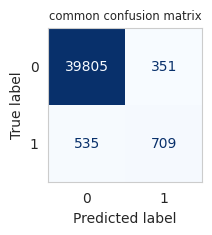

In [56]:
get_metrics(pred_lr, y_val, detail_stat=False)

### Experiment 1: Base model + new tokens

Базовая модель с добавленными новыми токенами, вектора которых инициализированы усредненными векторами составленного текстового описания.

In [57]:
model_bert_exp1 = model_mlm.bert

train_emb_exp1 = generate_emb(model_bert_exp1, tokenizer_tune, train_data['sentences'], batch_size=64)
val_emb_exp1 = generate_emb(model_bert_exp1, tokenizer_tune, val_data['sentences'], batch_size=64)

X_train_exp1, y_train_exp1 = x_y_split(train_data, train_emb_exp1)
X_val_exp1, y_val_exp1 = x_y_split(val_data, val_emb_exp1)

Map:   0%|          | 0/5986 [00:00<?, ? examples/s]

generate_embeddings:   0%|          | 0/94 [00:00<?, ?it/s]

Map:   0%|          | 0/828 [00:00<?, ? examples/s]

generate_embeddings:   0%|          | 0/13 [00:00<?, ?it/s]

Accuracy:       0.3684 (samples)
BCE:            0.0818

                micro     macro  weighted   samples
F1:             0.62      0.47      0.61      0.58
Precision:      0.68      0.56      0.67      0.61
Recall:         0.58      0.43      0.58      0.61



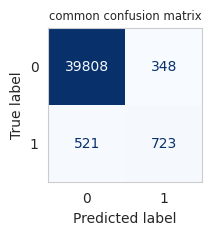

In [58]:
model_lr = MultiOutputClassifier(LogisticRegression(max_iter=10000, random_state=SEED))
model_lr.fit(X_train_exp1, y_train_exp1)
pred_lr_exp1 = model_lr.predict_proba(X_val_exp1)
pred_lr_exp1 = np.array(pred_lr_exp1)[:, :, 1].transpose(1, 0)

get_metrics(pred_lr_exp1, y_val_exp1, detail_stat=False)

Добавление новых токенов позволило на линейной регрессии получить чуть больший accuracy, примерно на **0.5%**. Так же немного повысились метрики F1, Precision и Recall при macro усреднении.

### Experiment 2: LoRA + new tokens

Модель, для которой были обучен адаптер LoRA и вектора новых токенов во входном слое эмбеддингов.

In [61]:
load_state = torch.load('model_save/mlm_lora2/step_1000.pth', map_location=DEVICE, weights_only=True)
model_mlm_lora.load_state_dict(load_state)
model_bert_exp2 = model_mlm_lora.base_model.model.bert

train_emb_exp2 = generate_emb(model_bert_exp2, tokenizer_tune, train_data['sentences'], batch_size=64)
val_emb_exp2 = generate_emb(model_bert_exp2, tokenizer_tune, val_data['sentences'], batch_size=64)

X_train_exp2, y_train_exp2 = x_y_split(train_data, train_emb_exp2)
X_val_exp2, y_val_exp2 = x_y_split(val_data, val_emb_exp2)

Map:   0%|          | 0/5986 [00:00<?, ? examples/s]

generate_embeddings:   0%|          | 0/94 [00:00<?, ?it/s]

Map:   0%|          | 0/828 [00:00<?, ? examples/s]

generate_embeddings:   0%|          | 0/13 [00:00<?, ?it/s]

Accuracy:       0.3539 (samples)
BCE:            0.0665

                micro     macro  weighted   samples
F1:             0.61      0.41      0.59      0.55
Precision:      0.71      0.53      0.69      0.58
Recall:         0.53      0.36      0.53      0.56



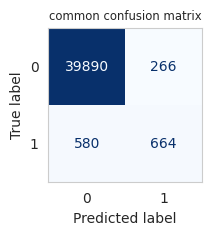

In [68]:
model_lr = MultiOutputClassifier(LogisticRegression(max_iter=10000, random_state=SEED))
model_lr.fit(X_train_exp2, y_train_exp2)
pred_lr_exp2 = model_lr.predict_proba(X_val_exp2)
pred_lr_exp2 = np.array(pred_lr_exp2)[:, :, 1].transpose(1, 0)

get_metrics(pred_lr_exp2, y_val_exp2, detail_stat=False)

А вот добавление адаптеров LoRA и дальнейшее обучение на задаче MLM в нашем случае ухудшило многие метрики, при использовании в качестве классификатора линейной регрессии. Улучшилась кросс-энтропия и уменьшилось общее количество ошибок первого рода (улучшился micro precision). Но уменьшилось значение основной метрики Accuracy и F1, Precision и Recall при macro усреднении.

Но линейную регрессию мы использовали лишь в качестве базового ориентира. Вероятнее всего в данных есть зависимости, которые могут плохо аппроксимироваться простой линейной функцией, поэтому далее в качестве классификатора будем использовать нелинейную модель и повторим все измерения на ней.

## Classification head

Напишем простую классификационную голову, состоящую из нескольких линейных слоев с нелинейными активациями. Помимо эмбеддингов в нее будет подаваться оценка от пользователя в качестве непрерывного признака.

In [63]:
class ClassifierHead(nn.Module):
    def __init__(self, num_labels: int, hidden_size: int):
        super().__init__()
        self.num_labels = num_labels
        self.hidden_size = hidden_size

        self.linear = nn.Sequential(
            nn.Linear(self.hidden_size + 1, 256),
            nn.ReLU(),
            nn.Dropout(.2),
            nn.Linear(256, self.hidden_size),
            nn.ReLU(),
        )
        
        self.classifier = nn.Sequential(
            nn.Dropout(.2),
            nn.Linear(self.hidden_size, num_labels),
        )

    def forward(self, emb, urating):
        """
        emb: BERT эмбеддинги [batch_size, hidden_size]
        urating: оценки пользователя [batch_size]
        """
        urating = urating.unsqueeze(1)
        x = torch.cat([emb, urating], dim=1)
        x = self.linear(x) + emb   # Residual connection
        return self.classifier(x)

In [64]:
hidden_size = model_bert.config.hidden_size

model_head_exp0 = ClassifierHead(num_labels, hidden_size).to(DEVICE)
model_head_exp1 = ClassifierHead(num_labels, hidden_size).to(DEVICE)
model_head_exp2 = ClassifierHead(num_labels, hidden_size).to(DEVICE)

get_model_size(model_head_exp0)

Model_size: 0.43M params

### Datasets with ready-made embeddings

Для того, что бы добавить некоторую регуляризацию (а с нашим маленьким датасетом это особенно актуально) воспользуемся случайным маскированием токенов, добавляя элемент случайности и предотвращая переобучение на специфических паттернах. Так модель будет учится извлекать информацию из контекста, игнорируя отдельные слова. Такой подход способствует улучшению способности модели к генерализации, так как она не будет полагаться на конкретные слова или фразы, а научится понимать общий смысл текста.

Заранее сгенерируем эмбеддинги применяя случайное маскирование; повторим операцию несколько раз (в нашем случае возьмем 4 эпохи) и получим набор данных, где для каждого текста из обучающего набора будут 4 варианта с разными маскированными токенами. Это позволит значительно сократить время обучения, так как на каждом шаге не потребуется заново вычислять эмбеддинги для входных данных. Вместо этого мы будем обучать только классификационную голову, используя уже готовые эмбеддинги.

In [65]:
def make_dataloaders_for_classification_head(model, tokenizer, train_data: dict, val_data: dict):
    """
    Создает даталоадеры для головы классификации, используя эмбеддинги и маскирование данных.

    Args:
        model: Обучаемая модель.
        tokenizer: Токенайзер, используемый для преобразования текстовых данных.
        train_data: Данные для обучения, содержащие ключи 'sentences', 'urating', 'labels'.
        val_data: Данные для валидации, содержащие ключи 'sentences', 'urating', 'labels'.

    Returns:
        tuple: Даталоадеры для обучения и валидации (train_loader_emb, val_loader_emb).
    """

    # Создание коллатора для случайного маскирования
    collator_mask = DataCollatorWithRandomMasking(
        tokenizer=tokenizer,
        prob=.15,
    )

    # Генерация эмбеддингов с маскированием для обучающих данных
    num_epochs = 4
    train_data_mask = {}
    train_data_mask['emb'] = generate_emb(
        model, 
        tokenizer, 
        train_data['sentences'], 
        batch_size=64, 
        num_epochs=num_epochs, 
        collate_fn=collator_mask
    )

    # Повторение данных для обучения, чтобы соответствовать количеству эпох
    train_data_mask['sentences'] = np.tile(train_data['sentences'], num_epochs)
    train_data_mask['urating'] = np.tile(train_data['urating'], num_epochs)
    train_data_mask['labels'] = np.tile(train_data['labels'], (num_epochs, 1))

    # Генерация эмбеддингов для валидационных данных
    val_data_new = val_data.copy()
    val_data_new['emb'] = generate_emb(model, tokenizer, val_data_new['sentences'], batch_size=64)

    # Создание датасета из эмбеддингов
    dataset_emb = DatasetDict({
        'train': Dataset.from_dict(train_data_mask),
        'val': Dataset.from_dict(val_data_new)
    })

    # Удаление текстовых данных, оставляя только эмбеддинги и признаки 'urating' и 'labels'
    dataset_emb = dataset_emb.remove_columns(['sentences'])
    dataset_emb.set_format('torch')

    # Создание даталоадеров для обучения и валидации
    batch_size = 512
    train_loader_emb = DataLoader(dataset_emb['train'], shuffle=True, batch_size=batch_size)
    val_loader_emb = DataLoader(dataset_emb['val'], shuffle=False, batch_size=batch_size)

    return train_loader_emb, val_loader_emb

In [66]:
# Создание даталоадеров
train_loader_exp0, val_loader_exp0 = make_dataloaders_for_classification_head(model_bert, tokenizer, train_data, val_data)
train_loader_exp1, val_loader_exp1 = make_dataloaders_for_classification_head(model_bert_exp1, tokenizer_tune, train_data, val_data)
train_loader_exp2, val_loader_exp2 = make_dataloaders_for_classification_head(model_bert_exp2, tokenizer_tune, train_data, val_data)

Map:   0%|          | 0/5986 [00:00<?, ? examples/s]

generate_embeddings:   0%|          | 0/376 [00:00<?, ?it/s]

Map:   0%|          | 0/828 [00:00<?, ? examples/s]

generate_embeddings:   0%|          | 0/13 [00:00<?, ?it/s]

Map:   0%|          | 0/5986 [00:00<?, ? examples/s]

generate_embeddings:   0%|          | 0/376 [00:00<?, ?it/s]

Map:   0%|          | 0/828 [00:00<?, ? examples/s]

generate_embeddings:   0%|          | 0/13 [00:00<?, ?it/s]

Map:   0%|          | 0/5986 [00:00<?, ? examples/s]

generate_embeddings:   0%|          | 0/376 [00:00<?, ?it/s]

Map:   0%|          | 0/828 [00:00<?, ? examples/s]

generate_embeddings:   0%|          | 0/13 [00:00<?, ?it/s]

### Metrics

In [67]:
metrics = MetricCollection({
    'ACC': AccuracySamples(),
    'F1': MultilabelF1Score(num_labels=num_labels, average='micro'),
    'P': MultilabelPrecision(num_labels=num_labels, average='micro'),
    'R': MultilabelRecall(num_labels=num_labels, average='micro'),
}).to(DEVICE)

### Experiment 0: Train

Базовая модель и базовый токенайзер.

In [89]:
optimizer = optim.AdamW(model_head_exp0.parameters(), lr=4e-4, weight_decay=.01)
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([2])).to(DEVICE)

scheduler = get_scheduler(
    'cosine', 
    optimizer, 
    num_warmup_steps=30, 
    num_training_steps=1000,
)

In [90]:
trainer = CustomTrainer(
    model_head_exp0, 
    train_loader_exp0, 
    val_loader_exp0, 
    optimizer,  
    scheduler, 
    criterion,
    metrics=metrics, 
    main_metric='ACC', 
    gradient_accumulation_steps=1,
    max_steps=1000,
    eval_steps=100,
    save_each_eval=False,
    exp_path='model_save/classifier_head_exp0', 
)

trainer.train()

Micro batch:           512
Mini batch:            512

Total global steps:    1000
Global steps in epoch: 47.0
Total epochs:          21.3


  0%|          | 0/1000 [00:00<?, ?it/s]

----------------------------TRAIN---------------------------- | -------------------VALID--------------------
 step       lr |     loss      ACC       F1        P        R |     loss      ACC       F1        P        R
  100  3.9e-04 |   0.3019   0.0525   0.0997   0.0704   0.1709 |   0.1160   0.2742   0.5285   0.6895   0.4285
  200  3.7e-04 |   0.1272   0.1956   0.4961   0.6461   0.4027 |   0.0867   0.3756   0.6529   0.7188   0.5981
  300  3.3e-04 |   0.0983   0.2912   0.6195   0.6901   0.5620 |   0.0804   0.3768   0.6588   0.6901   0.6302
  400  2.7e-04 |   0.0838   0.3584   0.6812   0.7235   0.6436 |   0.0789   0.3986   0.6686   0.7011   0.6391
  500  2.1e-04 |   0.0750   0.4056   0.7158   0.7430   0.6905 |   0.0782   0.4130   0.6773   0.7075   0.6495
  600  1.5e-04 |   0.0693   0.4426   0.7411   0.7601   0.7230 |   0.0783   0.4191   0.6786   0.7067   0.6527
  700  8.7e-05 |   0.0653   0.4625   0.7555   0.7714   0.7403 |   0.0782   0.4118   0.6767   0.7024   0.6527
  800  4.1e-05 |   

### Experiment 1: Train

Базовая модель с добавленными новыми токенами.

In [105]:
optimizer = optim.AdamW(model_head_exp1.parameters(), lr=8e-4, weight_decay=.01)
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([2])).to(DEVICE)

scheduler = get_scheduler(
    'cosine', 
    optimizer, 
    num_warmup_steps=30, 
    num_training_steps=2000,
)

In [106]:
trainer = CustomTrainer(
    model_head_exp1, 
    train_loader_exp1, 
    val_loader_exp1, 
    optimizer,  
    scheduler, 
    criterion,
    metrics=metrics, 
    main_metric='ACC', 
    gradient_accumulation_steps=1,
    max_steps=2000,
    eval_steps=200,
    save_each_eval=False,
    exp_path='model_save/classifier_head_exp1', 
)

trainer.train()

Micro batch:           512
Mini batch:            512

Total global steps:    2000
Global steps in epoch: 47.0
Total epochs:          42.6


  0%|          | 0/2000 [00:00<?, ?it/s]

----------------------------TRAIN---------------------------- | -------------------VALID--------------------
 step       lr |     loss      ACC       F1        P        R |     loss      ACC       F1        P        R
  200  7.9e-04 |   0.2285   0.0563   0.1344   0.1363   0.1326 |   0.1143   0.2536   0.5071   0.6844   0.4027
  400  7.3e-04 |   0.1254   0.1945   0.4902   0.6190   0.4058 |   0.0926   0.3466   0.6097   0.6970   0.5418
  600  6.5e-04 |   0.0995   0.2841   0.6042   0.6699   0.5503 |   0.0874   0.3623   0.6344   0.6733   0.5997
  800  5.3e-04 |   0.0846   0.3496   0.6683   0.7037   0.6362 |   0.0859   0.3623   0.6391   0.6738   0.6077
 1000  4.1e-04 |   0.0744   0.4014   0.7112   0.7305   0.6928 |   0.0866   0.3865   0.6437   0.6734   0.6166
 1200  2.8e-04 |   0.0678   0.4385   0.7379   0.7482   0.7280 |   0.0872   0.3804   0.6452   0.6737   0.6190
 1400  1.7e-04 |   0.0633   0.4667   0.7566   0.7617   0.7516 |   0.0877   0.3804   0.6429   0.6716   0.6166
 1600  7.9e-05 |   

### Experiment 2: Train

Модель, для которой были обучен адаптер LoRA и вектора новых токенов во входном слое эмбеддингов.

In [113]:
optimizer = optim.AdamW(model_head_exp2.parameters(), lr=7e-4, weight_decay=.01)
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([2])).to(DEVICE)

scheduler = get_scheduler(
    'cosine', 
    optimizer, 
    num_warmup_steps=30, 
    num_training_steps=2000,
)

In [114]:
trainer = CustomTrainer(
    model_head_exp2, 
    train_loader_exp2, 
    val_loader_exp2, 
    optimizer,  
    scheduler, 
    criterion,
    metrics=metrics, 
    main_metric='ACC', 
    gradient_accumulation_steps=1,
    max_steps=2000,
    eval_steps=200,
    save_each_eval=False,
    exp_path='model_save/classifier_head_exp2', 
)

trainer.train()

Micro batch:           512
Mini batch:            512

Total global steps:    2000
Global steps in epoch: 47.0
Total epochs:          42.6


  0%|          | 0/2000 [00:00<?, ?it/s]

----------------------------TRAIN---------------------------- | -------------------VALID--------------------
 step       lr |     loss      ACC       F1        P        R |     loss      ACC       F1        P        R
  200  6.9e-04 |   0.2281   0.0492   0.1346   0.1412   0.1285 |   0.1171   0.2307   0.4926   0.6421   0.3995
  400  6.4e-04 |   0.1276   0.1850   0.4778   0.6128   0.3915 |   0.0942   0.3333   0.5947   0.6900   0.5225
  600  5.7e-04 |   0.1006   0.2790   0.6013   0.6667   0.5475 |   0.0881   0.3708   0.6361   0.6804   0.5973
  800  4.7e-04 |   0.0849   0.3493   0.6674   0.7034   0.6349 |   0.0869   0.3708   0.6419   0.6843   0.6045
 1000  3.6e-04 |   0.0745   0.4018   0.7110   0.7315   0.6917 |   0.0865   0.3877   0.6520   0.6897   0.6182
 1200  2.5e-04 |   0.0677   0.4383   0.7376   0.7481   0.7273 |   0.0873   0.3925   0.6514   0.6913   0.6158
 1400  1.5e-04 |   0.0632   0.4675   0.7567   0.7617   0.7517 |   0.0883   0.3925   0.6530   0.6831   0.6254
 1600  6.9e-05 |   

Для каждого эксперимента используются разные параметры learning rate и max steps. Они подбирались для обеспечения лучшей сходимости в каждом конкретном случае.

**Exp 0:** По логам обучения видно, что использование эмбеддингов, полученных из стандартной модели и стандартного токенайзера, позволяет получить как более низкий loss, так и сойтись получается за меньшее число итераций.

**Exp 1:** При использовании базовой модели с новыми токенами для emoji наблюдается худшая сходимость по сравнению со стандартной моделью. Это можно объяснить несколькими причинами:
1. Неудачная инициализация начальных весов: Подбор слов и фраз для инициализации весов новых токенов мог быть не оптимальным. Это могло негативно повлиять на способность модели эффективно обучаться на этих данных.
2. Проблемы с усреднением эмбеддингов: Инициализация эмбеддингов во входном слое BERT с использованием усредненных векторов текстового описания эмодзи, хотя и выглядит перспективно, не является универсальным решением. Усреднение векторов не учитывает порядок слов и другие важные контекстуальные зависимости, что может ограничивать эффективность обучения. 

**Exp 2:** Fine tune модели на задаче MLM на домене пользовательских отзывов не привел к ожидаемому улучшению результатов для нашей основной задачи классификации. Рассмотрим возможные причины этого:
1. Параметры обучения и конфигурация LoRA могли быть выбраны не оптимально и оказались недостаточно эффективными для полноценной адаптации модели к новому домену.
2. Наше предположение о том, что emoji могут добавить полезный контекст к пользовательским отзывам, возможно, было ошибочным. Emoji имеют менее конвенциональные значения по сравнению со словами и вполне могут различными людьми интерпретироваться по-разному.
3. Возможно мы упираемся в архитектурные ограничения небольшой модели (по современным меркам). И с данным количеством параметрв, возможно, просто не получится вытянуть больше полезной информации из текста, для правильной классификации его на 50 пересекающихся классов.

## Final classification model

Возьмем базовую модель и добавим к ней ранее обученную классификационную голову.

In [71]:
class BertClassifier(nn.Module):
    def __init__(self, model_bert, model_head):
        super().__init__()
        self.bert = model_bert
        self.head = model_head

    def forward(self, input_ids, attention_mask, urating):
        outputs_bert = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        emb = outputs_bert.last_hidden_state[:, 0, :]
        logits = self.head(emb=emb, urating=urating)
        return logits

model_bert = AutoModel.from_pretrained(model_name).to(DEVICE)
model_head = ClassifierHead(num_labels, hidden_size)
model = BertClassifier(model_bert, model_head).to(DEVICE)

load_state = torch.load('model_save/classifier_head_exp0/best_loss.pth', map_location=DEVICE, weights_only=True)
model.head.load_state_dict(load_state)

<All keys matched successfully>

Заморозим градиенты в основной модели и будем окончательно дообучать только классификатор.

In [72]:
model.requires_grad_(False)
model.head.requires_grad_(True)

get_requires_grad(model, detail=True, only_true=True)

Model_size: 128.78M params || Trainable params: 0.43M (0.3362%)

Requires grad:
True:  6
False: 199

head.linear.0.weight        True
head.linear.0.bias          True
head.linear.3.weight        True
head.linear.3.bias          True
head.classifier.1.weight    True
head.classifier.1.bias      True


### Dataset

Так как в этот раз мы обучаем модель в сборе, то не будем ограничены набором заранее сгенерированных эмбеддингов и на каждом батче сможем случайно маскировать токены для внесения разнообразия в данные, что особенно полезно при небольшом датасете.

In [73]:
def tokenize_function(example):
    return tokenizer(example['sentences'], truncation=True, return_token_type_ids=False)

collator = DataCollatorWithPadding(tokenizer)

collator_mask = DataCollatorWithRandomMasking(
    tokenizer=tokenizer,
    prob=.15,
)

In [74]:
dataset_tokenized = DatasetDict({
    'train': Dataset.from_dict(train_data),
    'val': Dataset.from_dict(val_data),
    'test': Dataset.from_dict(test_data)
})

dataset_tokenized = dataset_tokenized.map(tokenize_function, batched=True, remove_columns=['sentences'])
dataset_tokenized.set_format('torch')

Map:   0%|          | 0/5986 [00:00<?, ? examples/s]

Map:   0%|          | 0/828 [00:00<?, ? examples/s]

Map:   0%|          | 0/16999 [00:00<?, ? examples/s]

In [75]:
BATCH_SIZE = 32


train_loader = DataLoader(
    dataset_tokenized['train'], 
    shuffle=True, 
    batch_size=BATCH_SIZE, 
    collate_fn=collator_mask,
)

val_loader = DataLoader(
    dataset_tokenized['val'], 
    shuffle=False, 
    batch_size=BATCH_SIZE, 
    collate_fn=collator,
)

test_loader = DataLoader(
    dataset_tokenized['test'], 
    shuffle=False, 
    batch_size=BATCH_SIZE, 
    collate_fn=collator,
)

### Train

Увеличим эффективный размер батча до 1024, что бы увеличить обобщающую способность и уменьшить эффект переобучения.

In [221]:
params = [p for p in model.parameters() if p.requires_grad]

optimizer = optim.AdamW(params, lr=9e-5, weight_decay=.05)
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([2])).to(DEVICE)

scheduler = get_scheduler(
    'cosine', 
    optimizer, 
    num_warmup_steps=30, 
    num_training_steps=500,
)

In [223]:
trainer = CustomTrainer(
    model, 
    train_loader, 
    val_loader, 
    optimizer,  
    scheduler, 
    criterion,
    metrics=metrics, 
    main_metric='ACC', 
    gradient_accumulation_steps=32,
    max_steps=500,
    eval_steps=50,
    save_each_eval=False,
    exp_path='model_save/final', 
)

trainer.train()

Micro batch:           32
Mini batch:            1024

Total global steps:    500
Global steps in epoch: 5.9
Total epochs:          85.1


  0%|          | 0/500 [00:00<?, ?it/s]

----------------------------TRAIN---------------------------- | -------------------VALID--------------------
 step       lr |     loss      ACC       F1        P        R |     loss      ACC       F1        P        R
   50  9.0e-05 |   0.0780   0.3912   0.7049   0.7341   0.6779 |   0.0781   0.4118   0.6841   0.6841   0.6841
  100  8.5e-05 |   0.0761   0.4032   0.7136   0.7386   0.6903 |   0.0781   0.4179   0.6851   0.6829   0.6873
  150  7.6e-05 |   0.0749   0.4099   0.7179   0.7414   0.6958 |   0.0782   0.4203   0.6841   0.6866   0.6817
  200  6.4e-05 |   0.0733   0.4201   0.7252   0.7460   0.7054 |   0.0780   0.4130   0.6817   0.6842   0.6793
  250  5.0e-05 |   0.0726   0.4234   0.7270   0.7468   0.7082 |   0.0781   0.4094   0.6854   0.6843   0.6865
  300  3.5e-05 |   0.0715   0.4272   0.7286   0.7467   0.7113 |   0.0782   0.4155   0.6825   0.6842   0.6809
  350  2.1e-05 |   0.0715   0.4292   0.7310   0.7474   0.7153 |   0.0781   0.4118   0.6830   0.6827   0.6833
  400  9.7e-06 |   

Лучшие результаты на прошлой стадии отдельного обучения классификатора:  
```
step       lr |     loss      ACC       F1        P        R |     loss      ACC       F1        P        R
 700  8.7e-05 |   0.0653   0.4625   0.7555   0.7714   0.7403 |   0.0782   0.4118   0.6767   0.7024   0.6527
```

По сравнению с предыдущей тренировкой на наборе заранее сгенерированных эмбеддингов, удалось слегка улучшить loss до **0.0780**, а так же выровнять precision и recall между собой.

### Validation

In [210]:
load_state = torch.load('model_save/final/step_200.pth', map_location=DEVICE, weights_only=True)
model.load_state_dict(load_state)

<All keys matched successfully>

predict:   0%|          | 0/26 [00:00<?, ?it/s]

Accuracy:       0.4130 (samples)
BCE:            0.0535

                micro     macro  weighted   samples
F1:             0.68      0.51      0.67      0.66
Precision:      0.68      0.54      0.68      0.67
Recall:         0.68      0.51      0.68      0.71



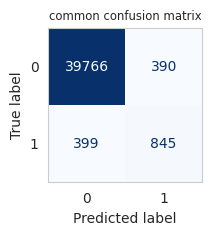


metrics for each class:
id         F1      P      R     num
 0        71%    71%    71%     145
 1        77%    74%    82%      65
 2        71%    68%    74%     121
 3        62%    67%    58%      67
 4        49%    48%    50%      26
 5        82%    82%    82%      11
 6        86%   100%    75%       4
 7        86%    75%   100%       6
 8        65%    64%    67%      27
 9         0%     0%     0%       2
10        56%    56%    56%      18
11        86%    90%    82%      22
12        92%    89%    94%     116
13         0%     0%     0%       7
14        37%    56%    28%      18
15        44%    58%    35%      20
16        64%    60%    69%      36
17         0%     0%     0%       2
18        69%    65%    73%      30
19        63%    72%    56%      50
20        32%    31%    33%      15
21        59%    67%    53%      15
22        67%    75%    60%       5
23        43%    62%    33%      15
24        67%   100%    50%       2
25         0%     0%     0%       3
26 

In [211]:
pred = get_predict(model, val_loader)
get_metrics(pred, y_val, threshold=.5)

На выходе получилась модель, которая примерно в одинаковых пропорциях совершает ошибки первого или второго рода при стандартном пороге в 0.5.  
Если посмотреть на статистики по каждому классу то видно, что на классах с небольшим количеством примеров (а соотношение классов в тренировочном и валидационном наборах для исходных данных примерно совпадает) модель ошибается ожидаемо чаще. Как уже было написано ранее, аугментации с помощью back translation не могут в полном мере заменить разнообразие реальных данных.

Взглянем на несколько конкретных примеров, на которых модель ошиблась наиболее сильно, отсортировав по кросс-энтропии для каждого примера.

In [271]:
show_predict(pred, y_val, val_data['sentences'], id2label, nums=5, random_samples=False)

Sentence: Сроки не всегда соответствуют
BCE: 0.3080

True labels:
  19:  (1.7%) Нет смысла
  23:  (0.0%) Больше акций/скидок

Pred labels (top 5):
   2: (79.9%) Время доставки не соответствует заявленому
   3: (61.0%) Регулярные опоздания
   4:  (7.4%) Не отследить реальное время доставки
  15:  (4.6%) Просроченные товары
  27:  (4.1%) Качество товаров
Sentence: Постоянные опозд-я,отсутсв.клиент-ти.На замеч.не класть карт-ку с землей в общий пакет с прод. не реагируют.Кл-ты моют прод-ты от земли. Всем плевать на жалобы,отписки по шаблону.Вкусвилл везёт прод. столько же,цены адекватнее,клиент-ть на высоте.👎🏻👎🏻
BCE: 0.3026

True labels:
   3: (38.1%) Регулярные опоздания
  17:  (1.9%) Не читаем комментарии
  31:  (0.8%) Замечания по работе сборщика
  36: (23.3%) Сравнивают с конкурентами

Pred labels (top 5):
  30: (61.1%) Качество поддержки
  37: (54.3%) Скидки за опоздание
   3: (38.1%) Регулярные опоздания
  12: (38.0%) Высокие цены
   0: (26.6%) Долгая доставка
Sentence: Ограничение 

1. В первом примере ошибка в исходной разметке данных. На мой взгляд модель правильно определила классы.
2. Второй текст содержит большое количество сокращений. Так же жалобы сразу на множество аспектов сервиса делает задачу классификации довольно сложной.
3. Ошибка может быть связана с тем, что модель выделила общий негатив о приложении, но не смогла правильно интерпретировать жалобы на просроченные товары. Так же похожая тематика меток (**"Не нравится интерфейс приложения"** и **"приложение зависает"**) могла привести к путанице.
4. Здесь модель корректно распознала **"Регулярные опоздания"**, но неправильно выделила "Качество поддержки", из за того, что большая часть отзыва относится к поддержке, но в положительном ключе. Категория **"Не тянет на тенденцию"** в ground truth выглядит сомнительно, возможно так же ошибка разметки; в описании заказчик предоставляет такое описание 39 класса - "Ставим там, где не подходит ни под одну тенденцию.".
5. Хотя модель правильно определила **"Качество товаров"** как основную метку, присутствие **"Долгая доставка"** в предсказаниях вызвано упоминанием неудобств с отслеживанием доставки. Модель не смогла уловить, что ждать доставку приходится по причине отсутствия возможности отслеживания. А отсутствие категорий "Нет в наличии товара" и "Неудобный поиск" в предсказании вероятно можно объяснить тем, что модель сфокусировалась на первой половине текста не рассмотрев заключение.

## Test predictions

In [290]:
pred_proba_test = get_predict(model, test_loader)
pred_test = (pred_proba_test >= .5).astype(int)

predict:   0%|          | 0/532 [00:00<?, ?it/s]

In [312]:
test_indices = np.array(test_df.index).reshape(-1, 1)
submission = np.hstack([test_indices, pred_test])
submission = pd.DataFrame(submission, columns=['index', *label_cols])
submission.to_csv('submission.csv', index=False)

## Summary

#### Что было сделано:
1. Произведен исследовательский анализ данных, составлены различные графики.
2. Проведено обучение модели классификации текста. Выбрана оптимальная модель на которой сделаны предсказания для тестовой выборки.
3. Проведен эксперимент по дообучению на задаче Masked Language Modeling (MLM) для домена пользовательских отзывов.
4. Проведен эксперимент с включением новых токенов для emoji, чтобы понять их влияние на качество классификации.
5. Выполнен анализ ошибок модели на примерах с высокой кросс-энтропией.

#### Что можно улучшить:
1. Продолжить эксперименты с различными подходами к аугментации и адаптации моделей, чтобы выявить наилучшие стратегии для данного домена.
2. Применение более глубоких или сложных моделей может значительно улучшить обработку сложных языковых конструкций и повысить общее качество классификации.

#### Рекомендации заказчику:
1. **Расширение датасета:** Для достижения более устойчивых и точных результатов рекомендуется собрать и аннотировать больший объем данных. Как минимум увеличить количество примеров объектов минорных классов.
2. **Анализ и улучшение данных:** Провести анализ текущих данных на предмет возможных ошибок и неоднозначностей, что поможет улучшить качество предсказаний.